In [1]:
!pip install vesuvius
!vesuvius.accept_terms --yes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 64.0 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=5b47ab4f70e33dd32e8cf2ef89b1ad8a34882305ebe4c717561a3ccfad1bb198
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree

    ## LICENSE

    The PHerc. 172 (Scroll 5) dataset Â© 2024 by Scroll Prize and the Bodleian Library is licensed under CC BY-NC 4.0: https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt.

    All other Vesuvius Challenge datasets are bound by the following terms:

    By registering for downloads from the EduceLab-Scrolls Dataset and Vesuvius Challenge Discord Server, I agree to license the data from Vesuvius Challenge* under the following licensing terms:
    - I agree that 

In [2]:
import vesuvius
from vesuvius import Volume

Let us print the list of available segments for Scroll 1:

In [3]:
files = vesuvius.list_files()

segment_ids = list(files['1']['54']['7.91']['segments']) # Select segments from Scroll 1 scanned at 54 keV and 7.91 um resolution

print(f"Number of segments: {len(segment_ids)}")
print(f"Example segment IDs: {segment_ids[:5]}")

Number of segments: 250
Example segment IDs: ['20230503225234', '20230504093154', '20230504094316', '20230504125349', '20230504171956']


Wow, there are many! Let us choose one!
### Data download
We can work with segment `20230827161847` since we know it's interesting.
We start by fetching a "surface volume", a flattened region of micro-CT surrounding this papyrus surface.

In [4]:
segment_id = 20230827161847
segment = Volume(segment_id, normalize=True)

segment.shape(0)

(65, 9163, 5048)

As you have seen in the previous tutorial, the previous command only instantiates an object without downloading the data.
For a segment, the special method `segment.download_inklabels()` is automatically called and the ink labels, if available, are downloaded in the `self.inklabel` variable. If the ink labels are not available `segment.inklabel` will be an empty numpy array filled with 0s.

Let us visualize the layer that is supposed to be on the recto surface (the "front side," with text) of the sheet of papyrus.
The segmentation is a mesh that is meant to follow this recto surface, so we want the middle slice of the surface volume.

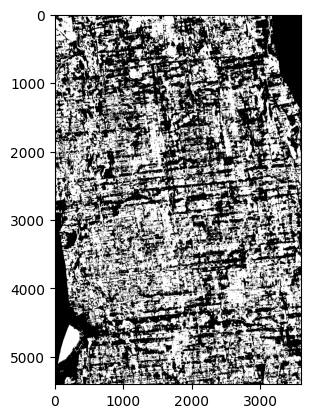

In [5]:
from matplotlib import pyplot as plt

surface_volume_slices = segment.shape(0)[0]
central_slice = surface_volume_slices // 2

plt.imshow(segment[central_slice, 200:5600,1000:4600] >= 0.29, cmap = "gray")

We can visualize the ink labels for this segment, focusing just on the upper area, and render them on top of the papyrus sheet:

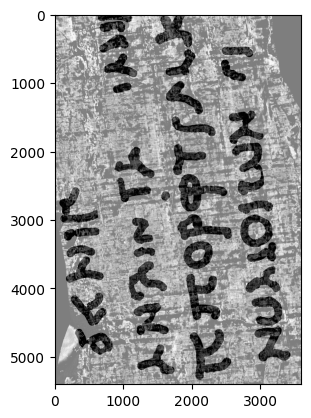

In [6]:
plt.imshow(segment[32,200:5600,1000:4600], cmap='gray')
plt.imshow(segment.inklabel[200:5600,1000:4600], cmap='binary', alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

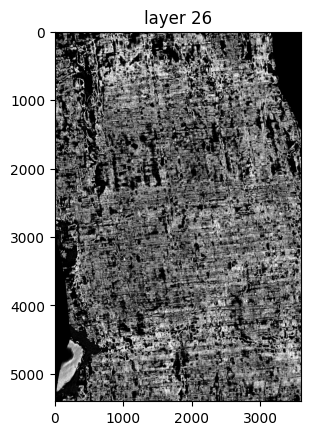

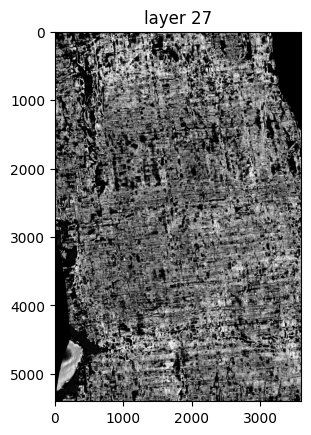

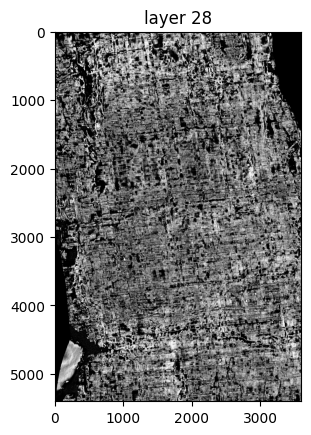

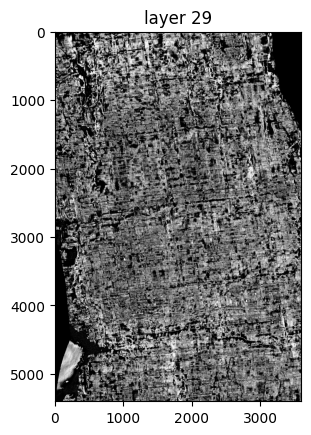

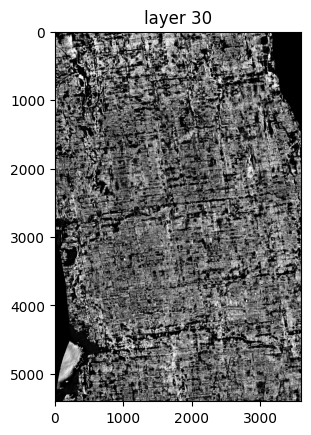

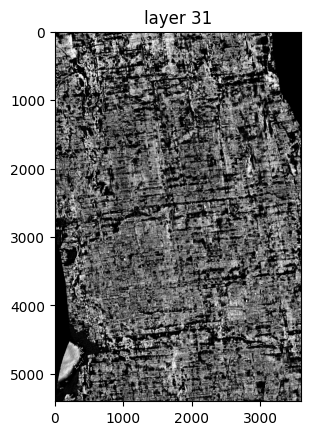

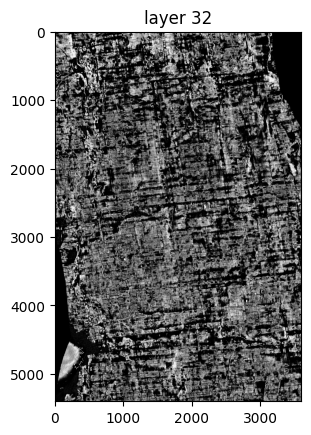

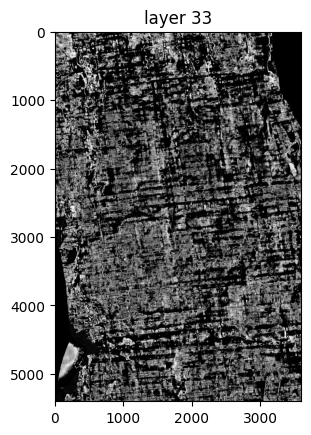

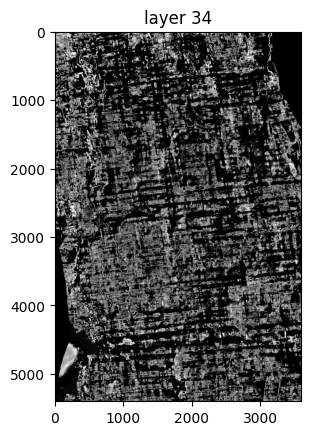

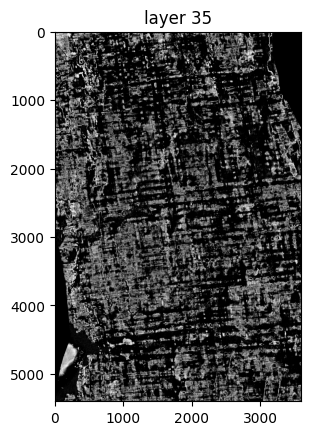

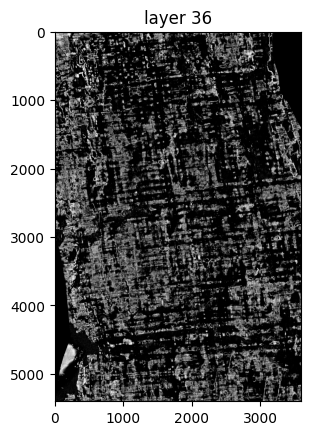

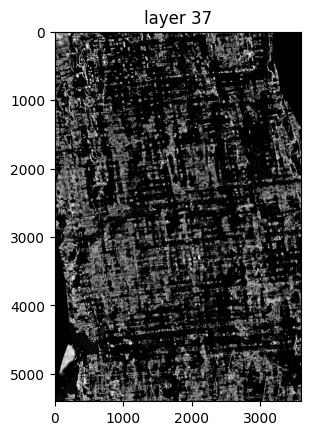

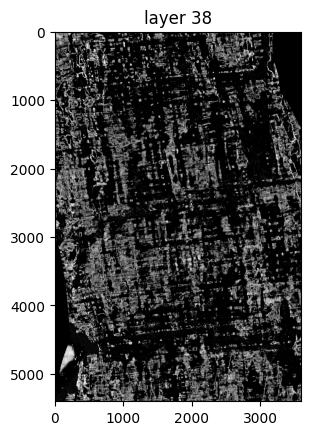

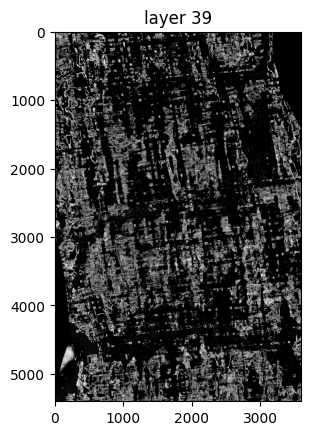

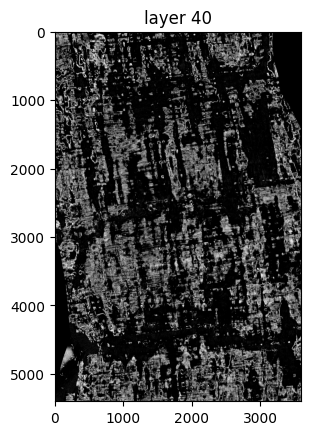

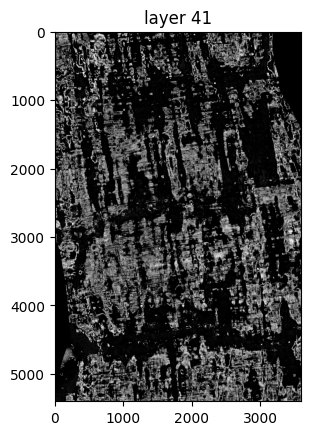

In [7]:
for i in range(26, 42):
    plt.imshow(segment[i,200:5600,1000:4600], cmap='gray')
    plt.title(f"layer {i}")
    plt.show()

Keep in mind that the papyrus was never physically open and this label was created by inspecting the segment and noticing some "[crackle](https://caseyhandmer.wordpress.com/2023/08/05/reading-ancient-scrolls/)" pattern on the surface. Therefore, the ink labels themselves that we are going to use for training a deep learning model are not perfect. But they are sufficient for detecting ink elsewhere in the scroll!

For ink detection we are going to use a stack of surface volume slices centered around the central slice (z=32).

If the central slice follows the recto surface, why do we need more slices? Two reasons: 1) the ink itself is 3D (has some thickness), so we want to capture it, and 2) segmentation is not perfect, so we want to provide some margin for small segmentation errors and still be sure we capture the surface with ink.

In the next cells we are going to define the classes to create a Dataset and an ink detection model.
The dataset will comprise many overlapping square tiles in the coordinates `(Y,X)` with a thickness `Z` and sides of size `TILE_SIZE`.
The amount of overlap is given by `STRIDE`.
Every one of these tiles will have a corresponding 2D ink label associated with it.

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import numpy as np

class VolumetricDataset(Dataset):
    def __init__(self, volume, label, tile_size, stride, validation_zone, valid=False):
        """
        Initialize the dataset with the volume and label.

        Args:
            volume (np.ndarray): The volumetric image of shape (Z, Y, X).
            label (np.ndarray): The 2D label of shape (Y, X).
            tile_size (int): The size of the tiles to extract along the Y and X dimensions.
            stride (int): The stride for extracting tiles along the Y and X dimensions.
        """
        self.volume = volume
        self.label = label
        self.tile_size = tile_size
        self.stride = stride
        self.validation_zone = validation_zone
        self.valid = valid
        self.tiles, self.labels, self.corners = self.extract_tiles()

    def extract_tiles(self):
        """
        Extract 3D tiles from the volume and corresponding 2D labels.

        Returns:
            tiles (list): A list of 3D tiles.
            labels (list): A list of 2D labels corresponding to the tiles.
        """
        Z, Y, X = self.volume.shape
        tiles = []
        labels = []
        corners = []
        CNT = 0
        flag = False
        # Generate 3D tiles by moving along the Y and X axes
        for y in range(0, Y - self.tile_size + 1, self.stride):
            for x in range(0, X - self.tile_size + 1, self.stride):
                if self.valid is False:
                    if (y + self.tile_size < self.validation_zone[0]) or (y > self.validation_zone[1]):
                        if (x + self.tile_size < self.validation_zone[2]) or (x > self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            # was before, but now I want binary label: having > 50% ink or not
                            # if np.sum(label_tile)/self.tile_size**2 > 0.05: # at least 5% of ink
                                # tiles.append(tile)
                                # labels.append(label_tile)
                                # corners.append([y,x])
                            if np.sum(label_tile)/self.tile_size**2 > 0.001: # at least 1% of ink, not many black
                                flag = True
                                tiles.append(tile)
                                #maybe add label smoothing?
                                if np.sum(label_tile)/self.tile_size**2 > 0.5:
                                    labels.append(1.0)
                                    CNT += 1
                                else:
                                    labels.append(0.0)
                                corners.append([y,x])
                            elif flag:
                                flag = False
                                tiles.append(tile)
                                if np.sum(label_tile)/self.tile_size**2 > 0.5:
                                    labels.append(1.0)
                                    CNT += 1
                                else:
                                    labels.append(0.0)
                                corners.append([y,x])
                else:
                    if (y >= self.validation_zone[0]) and (y + self.tile_size <= self.validation_zone[1]):
                        if (x >= self.validation_zone[2]) and (x + self.tile_size <= self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            tiles.append(tile)
                            if np.sum(label_tile)/self.tile_size**2 > 0.5:
                                labels.append(1.0)
                                CNT += 1
                            else:
                                labels.append(0.0)
                            corners.append([y,x])
        print(CNT)
        return tiles, labels, corners

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]  # Shape [tile_size, tile_size]
        label = self.labels[idx]
        corners = self.corners[idx]
        # Convert to torch tensors
        tile = torch.tensor(tile, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        corners = torch.tensor(corners, dtype=torch.int).unsqueeze(0)
        return tile, label, corners

We create two datasets: one for everything outside the red square, that will be used to train the model, and one for what's inside the red square, that we will use to validate the capability of the model to detect ink.

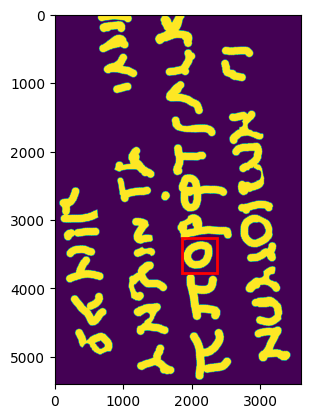

In [8]:
from matplotlib import patches
rect = (1860, 3260, 512, 512)
fig, ax = plt.subplots()
ax.imshow(segment.inklabel[200:5600,1000:4600]/255)
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [9]:
validation_rect = [3260, 3260+512, 1860, 1860+512]

calculating fractal features

In [10]:
from re import X
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

def fractal_dimension(binary):
    min_dim = min(binary.shape[0], binary.shape[1])
    scales = np.logspace(0, 1, num=6, base=min_dim, dtype=int)
    scales = np.unique(scales)
    counts = []
    for scale in scales:
        if scale < 1:
            continue
        count = 0
        i = 0
        while i < binary.shape[0]:
            j = 0
            while j < binary.shape[1]:
                cell = binary[i:i+scale, j:j+scale]
                count += cell.any()
                j += scale
            i += scale
        counts.append(count)
    if len(counts) < 2:
        return 0.0
    with np.errstate(divide='ignore', invalid='ignore'):
        coeffs = np.polyfit(np.log(1/scales), np.log(counts), 1)
    return coeffs[0] if not np.isnan(coeffs[0]) else 0.0

def calculate_fractal_features(image, scales =  [2,4,8,16,32]):
    threshold = image.mean()
    binary = image > threshold
    max_window_size = min(image.shape[0], image.shape[1]) // 2
    features = []
    for w in scales:
        if w > max_window_size:
            continue
        for i in range(0, binary.shape[0], w):
            for j in range(0, binary.shape[1], w):
                cell = binary[i:i+w, j:j+w]
                features.append(fractal_dimension(cell))
    return features

def calc_fractal_features(input_volume, z_step = 1, scales = [2,4,8,16,32]):
    fractal_features = []
    batch_size, channels, z, y, x = input_volume.shape
    for b in range(batch_size):
        batch_features = []
        for z_slice_ind in range(0, z, z_step):
            z_slice = input_volume[b, 0, z_slice_ind].numpy()
            features = calculate_fractal_features(z_slice, scales=scales)
            batch_features.append(features)
        fractal_features.append(batch_features)

    fractal_tensor = torch.tensor(np.array(fractal_features), dtype=torch.float32)
    return fractal_tensor

class FractalNet(nn.Module):
    def __init__(self, z_dim=16, y = 16, x = 16, z_step = 1, scales = [2,4,8,16,32]):
        super().__init__()
        self.y = y
        self.x = x
        self.z_dim = z_dim
        self.z_step = z_step
        self.scales = scales
        input_volume = torch.rand(1, 1, 1, y, x)  # Simulated input
        self.feat_dim = calc_fractal_features(input_volume, z_step, scales).shape[2]
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(z_dim//z_step * self.feat_dim, 10),
            nn.ReLU(),
            #nn.Linear(100, 50),
            #nn.ReLU(),
            nn.Linear(10, 1),
        )


    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x.view(-1, 1)


In [11]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
# tile_size = 256  # Size of the tile in the YX dimension
# stride = 128  # Stride for moving the tile in the YX dimension
# batch_size = 2
# z_depth = 16 # thickness of the tile
# Create the dataset
# dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
# valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [38]:
# made smaller tile_size
tile_size = 16  # Size of the tile in the YX dimension
stride = 16  # Stride for moving the tile in the YX dimension
batch_size = 32
#z_depth = 16 # thickness of the tile
# Create the dataset
#dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
#valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

dataset = VolumetricDataset(segment[32:33,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[32:33,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)
# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

9504
433


In [39]:
len(dataset)

12272

In [40]:
z, y, x = 1, 16, 16
z_step = 1
scales = [4,6,8]

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FractalNet(z, y, x, z_step, scales).to(device)
initialize_weights(model)

In [41]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
NUM_EPOCHS = 10
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

11it [00:02,  3.70it/s]00:00<?, ?it/s]

7.108018308877945 0.7108018308877945


21it [00:05,  3.81it/s]

13.88452896475792 0.6942264482378959


31it [00:08,  3.82it/s]

21.451381415128708 0.7150460471709569


41it [00:10,  3.56it/s]

28.032051771879196 0.7008012942969799


50it [00:13,  3.63it/s]

34.64857107400894 0.6929714214801789
34.64857107400894 0.6929714214801789


100%|██████████| 31/31 [00:08<00:00,  3.83it/s]


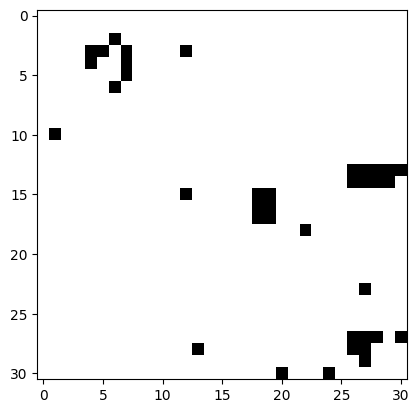

61it [00:24,  2.92it/s]

41.46858063340187 0.6911430105566978


71it [00:27,  3.70it/s]

48.16247087717056 0.6880352982452937


81it [00:30,  3.66it/s]

54.23564687371254 0.6779455859214067


91it [00:32,  3.60it/s]

60.07699790596962 0.667522198955218


100it [00:35,  3.73it/s]

65.82718643546104 0.6582718643546105
65.82718643546104 0.6582718643546105


100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


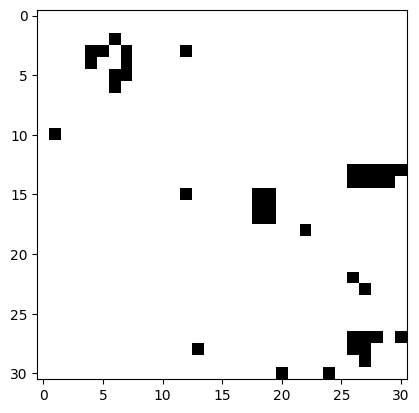

111it [00:46,  2.96it/s]

71.66148653626442 0.6514680594205856


121it [00:49,  3.49it/s]

77.68284288048744 0.647357024004062


131it [00:51,  3.74it/s]

84.0232084095478 0.6463323723811369


141it [00:54,  3.75it/s]

90.02370288968086 0.6430264492120061


150it [00:56,  3.72it/s]

96.71030205488205 0.644735347032547
96.71030205488205 0.644735347032547


100%|██████████| 31/31 [00:08<00:00,  3.84it/s]


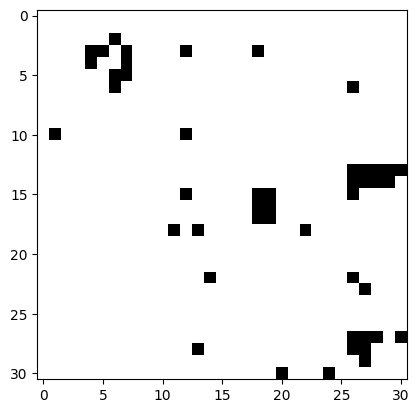

161it [01:08,  2.88it/s]

102.57971933484077 0.6411232458427548


171it [01:10,  3.65it/s]

107.83215150237083 0.6343067735433578


181it [01:13,  3.56it/s]

114.10442391037941 0.6339134661687745


191it [01:16,  3.57it/s]

120.88933417201042 0.636259653536897


200it [01:18,  3.58it/s]

127.25279960036278 0.6362639980018139
127.25279960036278 0.6362639980018139


100%|██████████| 31/31 [00:08<00:00,  3.70it/s]


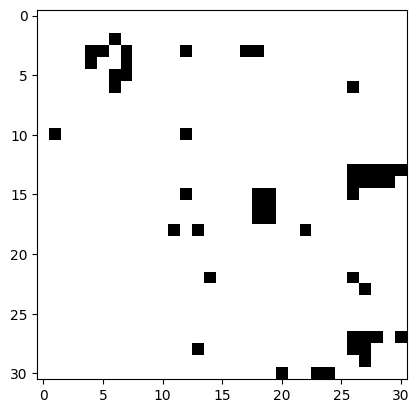

211it [01:30,  2.89it/s]

132.940599411726 0.6330504733891714


221it [01:33,  3.52it/s]

138.78158792853355 0.6308253996751525


231it [01:36,  3.65it/s]

145.30320537090302 0.6317530668300131


241it [01:38,  3.58it/s]

150.7814199924469 0.6282559166351954


250it [01:41,  3.69it/s]

156.47215086221695 0.6258886034488678
156.47215086221695 0.6258886034488678


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


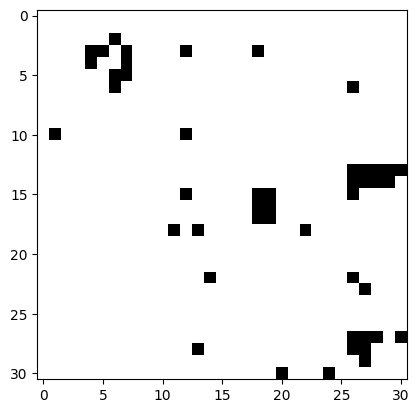

261it [01:52,  2.73it/s]

162.4023430943489 0.6246243965167265


271it [01:55,  3.66it/s]

168.3467544913292 0.6235064981160341


281it [01:58,  3.61it/s]

173.9276506304741 0.6211701808231217


291it [02:00,  3.61it/s]

180.66489726305008 0.6229824043553451


300it [02:03,  3.59it/s]

186.47829005122185 0.6215943001707395
186.47829005122185 0.6215943001707395


100%|██████████| 31/31 [00:08<00:00,  3.83it/s]


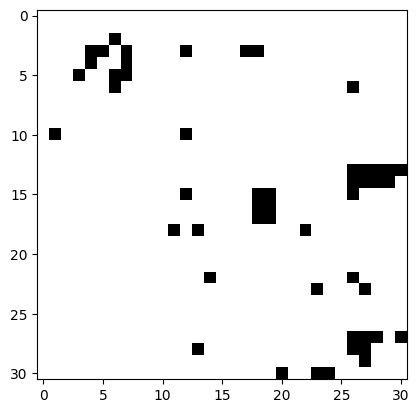

311it [02:14,  2.94it/s]

192.76715418696404 0.6218295296353679


321it [02:17,  3.63it/s]

199.05283257365227 0.6220401017926633


331it [02:20,  3.61it/s]

205.17145198583603 0.6217316726843516


341it [02:22,  3.37it/s]

211.11627620458603 0.6209302241311354


350it [02:25,  3.67it/s]

217.14309427142143 0.6204088407754899
217.14309427142143 0.6204088407754899


100%|██████████| 31/31 [00:08<00:00,  3.79it/s]


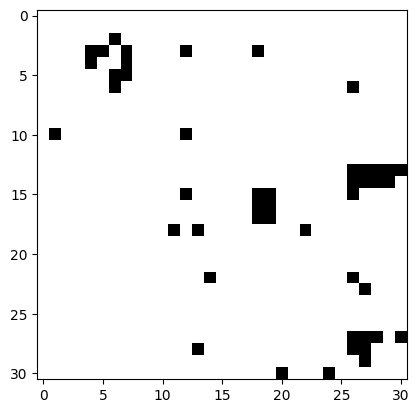

361it [02:36,  2.89it/s]

222.1216151714325 0.6170044865873124


371it [02:39,  3.64it/s]

228.02383622527122 0.616280638446679


381it [02:42,  3.69it/s]

233.8827737569809 0.6154809835710023


384it [02:42,  2.36it/s]
11it [00:02,  3.68it/s]02:42<24:26, 162.91s/it]

6.1677201092243195 0.616772010922432


21it [00:05,  3.71it/s]

11.786128550767899 0.5893064275383949


31it [00:08,  3.68it/s]

17.84990581870079 0.5949968606233597


41it [00:11,  3.56it/s]

23.64413022994995 0.5911032557487488


50it [00:13,  3.70it/s]

29.480737417936325 0.5896147483587265
29.480737417936325 0.5896147483587265


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


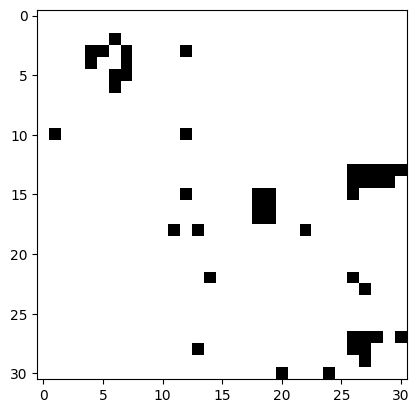

61it [00:24,  2.96it/s]

35.294508308172226 0.5882418051362037


71it [00:27,  3.68it/s]

40.80561405420303 0.5829373436314719


81it [00:30,  3.59it/s]

46.736425310373306 0.5842053163796663


91it [00:33,  3.76it/s]

52.18152317404747 0.5797947019338607


100it [00:35,  3.64it/s]

58.36609134078026 0.5836609134078026
58.36609134078026 0.5836609134078026


100%|██████████| 31/31 [00:08<00:00,  3.80it/s]


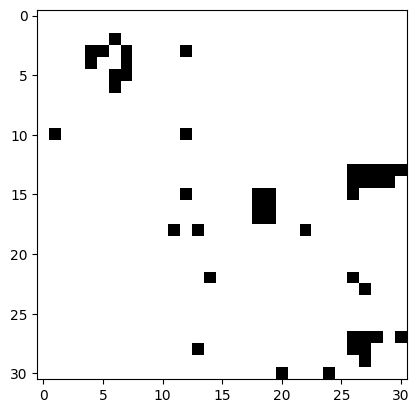

111it [00:46,  2.90it/s]

64.14471876621246 0.5831338069655678


121it [00:49,  3.64it/s]

69.64404952526093 0.5803670793771744


131it [00:52,  3.64it/s]

75.95089781284332 0.5842376754834102


141it [00:55,  3.63it/s]

81.50569280982018 0.5821835200701441


150it [00:57,  3.66it/s]

86.83246758580208 0.5788831172386805
86.83246758580208 0.5788831172386805


100%|██████████| 31/31 [00:08<00:00,  3.77it/s]


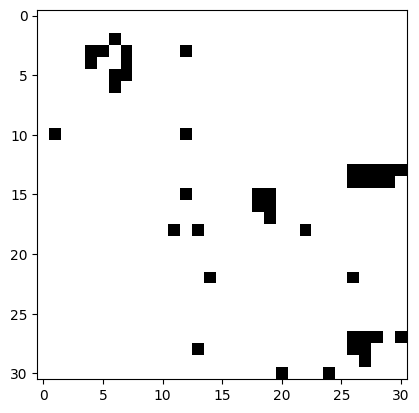

161it [01:08,  2.92it/s]

92.95046475529671 0.5809404047206044


171it [01:11,  3.63it/s]

98.73396709561348 0.5807880417389029


181it [01:14,  3.43it/s]

104.58874872326851 0.5810486040181584


191it [01:17,  3.57it/s]

110.18303799629211 0.5799107262962743


200it [01:19,  3.53it/s]

115.39245450496674 0.5769622725248337
115.39245450496674 0.5769622725248337


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


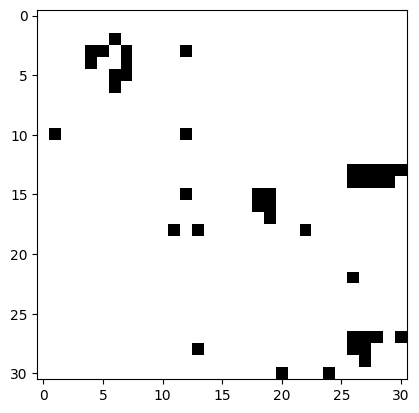

211it [01:31,  2.89it/s]

120.84867721796036 0.5754698915140969


221it [01:33,  3.58it/s]

126.99683898687363 0.5772583590312438


231it [01:36,  3.66it/s]

132.31398406624794 0.5752781915923824


241it [01:39,  3.68it/s]

137.98274412751198 0.5749281005313


250it [01:41,  3.60it/s]

143.66649296879768 0.5746659718751908
143.66649296879768 0.5746659718751908


100%|██████████| 31/31 [00:08<00:00,  3.73it/s]


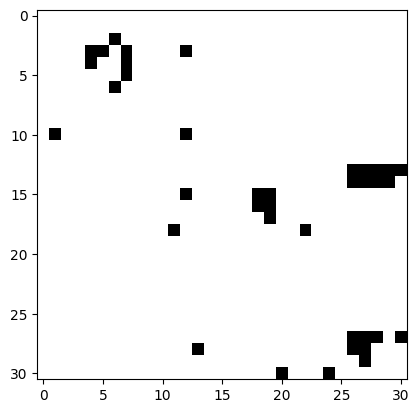

261it [01:53,  2.89it/s]

149.1506599187851 0.5736563843030196


271it [01:56,  3.57it/s]

155.01997661590576 0.5741480615403917


281it [01:58,  3.67it/s]

160.3386756181717 0.5726381272077561


291it [02:01,  3.65it/s]

165.80849355459213 0.5717534260503176


300it [02:04,  3.67it/s]

170.9774450659752 0.5699248168865839
170.9774450659752 0.5699248168865839


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


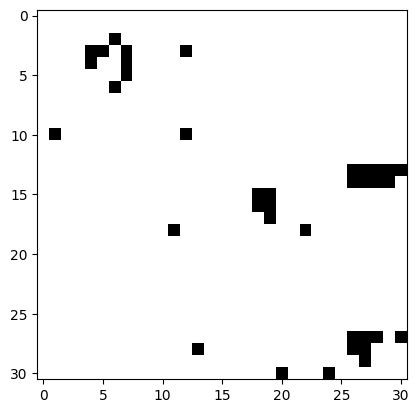

311it [02:15,  2.91it/s]

176.99742785096169 0.5709594446805215


321it [02:18,  3.51it/s]

182.5512029826641 0.5704725093208254


331it [02:20,  3.63it/s]

187.9928156733513 0.5696751990101554


341it [02:23,  3.69it/s]

193.18156814575195 0.5681810827816234


350it [02:26,  3.74it/s]

198.39862370491028 0.5668532105854579
198.39862370491028 0.5668532105854579


100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


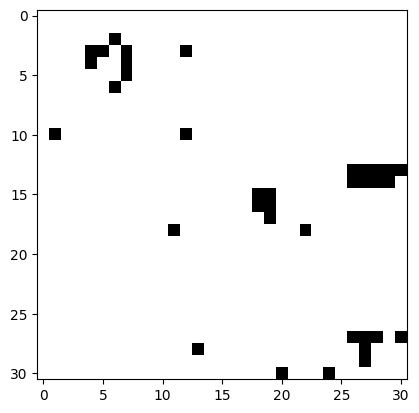

361it [02:37,  2.87it/s]

204.26134598255157 0.56739262772931


371it [02:40,  3.58it/s]

210.0446045100689 0.5676881202974835


381it [02:42,  3.67it/s]

215.80307897925377 0.5679028394190888


384it [02:43,  2.35it/s]
11it [00:02,  3.72it/s]05:26<21:46, 163.32s/it]

5.512685686349869 0.5512685686349869


21it [00:05,  3.58it/s]

11.384763807058334 0.5692381903529167


31it [00:08,  3.62it/s]

16.739015638828278 0.5579671879609426


41it [00:11,  3.66it/s]

22.44021487236023 0.5610053718090058


50it [00:13,  3.70it/s]

28.797281086444855 0.5759456217288971
28.797281086444855 0.5759456217288971


100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


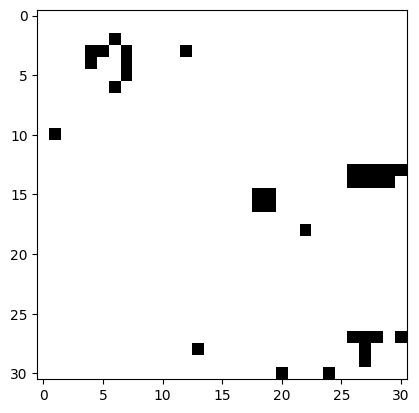

61it [00:24,  2.96it/s]

34.671772837638855 0.5778628806273143


71it [00:27,  3.57it/s]

40.13341063261032 0.5733344376087188


81it [00:30,  3.71it/s]

45.676474779844284 0.5709559347480535


91it [00:33,  3.72it/s]

50.81075841188431 0.5645639823542701


100it [00:35,  3.68it/s]

56.001180559396744 0.5600118055939675
56.001180559396744 0.5600118055939675


100%|██████████| 31/31 [00:08<00:00,  3.77it/s]


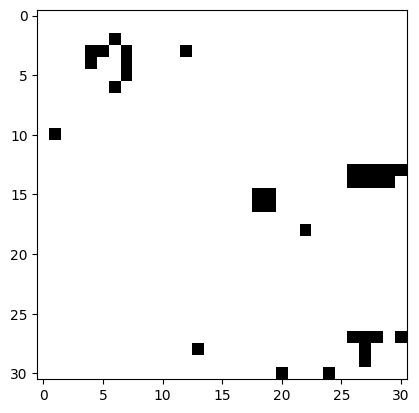

111it [00:46,  2.91it/s]

62.00587111711502 0.5636897374283184


121it [00:49,  3.74it/s]

66.8779865205288 0.55731655433774


131it [00:52,  3.67it/s]

72.85070207715034 0.5603900159780796


141it [00:55,  3.69it/s]

78.80284133553505 0.5628774381109647


150it [00:57,  3.70it/s]

84.24012523889542 0.5616008349259695
84.24012523889542 0.5616008349259695


100%|██████████| 31/31 [00:08<00:00,  3.87it/s]


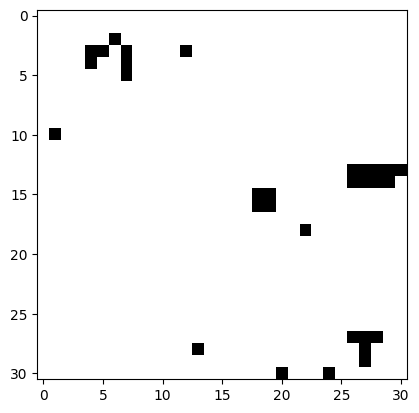

161it [01:08,  2.89it/s]

89.86985445022583 0.5616865903139114


171it [01:11,  3.72it/s]

95.46283310651779 0.5615460770971635


181it [01:14,  3.68it/s]

101.14206877350807 0.5619003820750449


191it [01:16,  3.63it/s]

107.03050202131271 0.5633184316911195


200it [01:19,  3.76it/s]

112.579191416502 0.56289595708251
112.579191416502 0.56289595708251


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


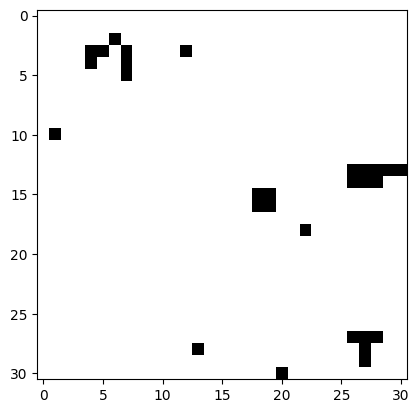

211it [01:30,  2.97it/s]

118.66266098618507 0.5650602904104051


221it [01:33,  3.65it/s]

124.1040970981121 0.564109532264146


231it [01:35,  3.72it/s]

129.6813421845436 0.563831922541494


241it [01:38,  3.63it/s]

135.1357392668724 0.5630655802786351


250it [01:41,  3.69it/s]

140.1253777742386 0.5605015110969543
140.1253777742386 0.5605015110969543


100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


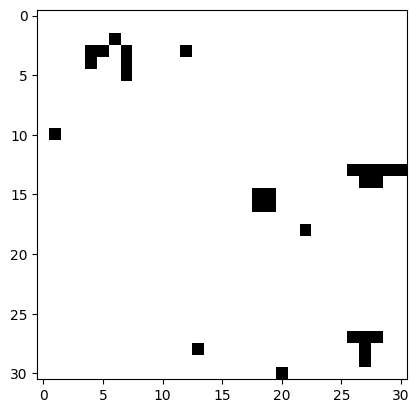

261it [01:52,  2.87it/s]

145.73020547628403 0.5605007902934


271it [01:54,  3.69it/s]

151.3376618027687 0.560509858528773


281it [01:57,  3.73it/s]

156.4316683113575 0.5586845296834196


291it [02:00,  3.78it/s]

161.70211979746819 0.5575935165429937


300it [02:02,  3.74it/s]

166.98858186602592 0.5566286062200864
166.98858186602592 0.5566286062200864


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


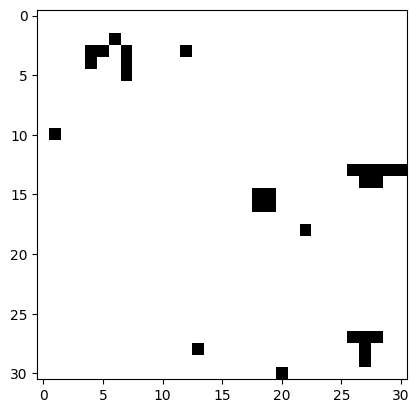

311it [02:13,  2.98it/s]

172.76399436593056 0.557303207632034


321it [02:16,  3.57it/s]

177.87306827306747 0.5558533383533358


331it [02:19,  3.77it/s]

183.43355357646942 0.5558592532620286


341it [02:21,  3.76it/s]

188.68773090839386 0.5549639144364525


350it [02:24,  3.78it/s]

193.98336777091026 0.5542381936311722
193.98336777091026 0.5542381936311722


100%|██████████| 31/31 [00:07<00:00,  3.88it/s]


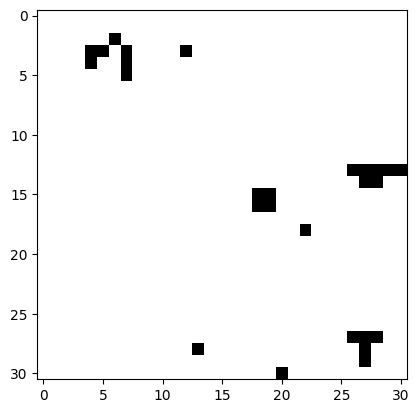

361it [02:35,  2.95it/s]

199.44667586684227 0.5540185440745619


371it [02:38,  3.54it/s]

205.08239024877548 0.5542767304020959


381it [02:40,  3.70it/s]

210.2967348098755 0.5534124600259881


384it [02:41,  2.38it/s]
11it [00:02,  3.70it/s]08:08<18:57, 162.51s/it]

5.93687117099762 0.593687117099762


21it [00:05,  3.61it/s]

11.184328317642212 0.5592164158821106


31it [00:08,  3.66it/s]

16.158533185720444 0.5386177728573481


41it [00:11,  3.60it/s]

21.751847684383392 0.5437961921095849


50it [00:13,  3.70it/s]

27.010414719581604 0.5402082943916321
27.010414719581604 0.5402082943916321


100%|██████████| 31/31 [00:08<00:00,  3.84it/s]


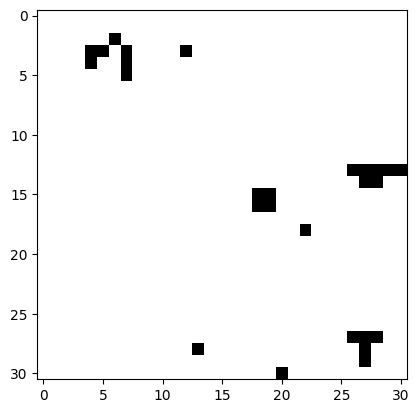

61it [00:24,  2.89it/s]

32.695450991392136 0.5449241831898689


71it [00:27,  3.73it/s]

38.79397904872894 0.5541997006961278


81it [00:30,  3.73it/s]

44.309508979320526 0.5538688622415066


91it [00:33,  3.56it/s]

50.56883627176285 0.5618759585751427


100it [00:35,  3.67it/s]

56.04998633265495 0.5604998633265496
56.04998633265495 0.5604998633265496


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


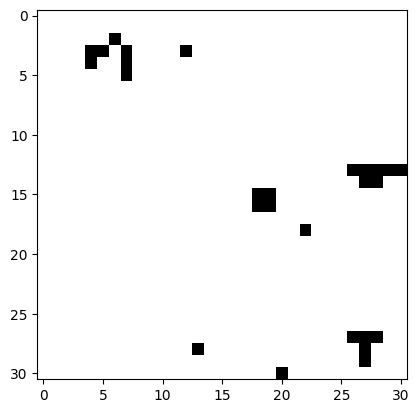

111it [00:46,  2.96it/s]

61.2919442653656 0.5571994933215054


121it [00:49,  3.68it/s]

66.4990707039833 0.5541589225331942


131it [00:52,  3.68it/s]

71.71027117967606 0.5516174706128928


141it [00:55,  3.59it/s]

77.21890926361084 0.5515636375972203


150it [00:57,  3.68it/s]

82.71576327085495 0.5514384218056997
82.71576327085495 0.5514384218056997


100%|██████████| 31/31 [00:08<00:00,  3.72it/s]


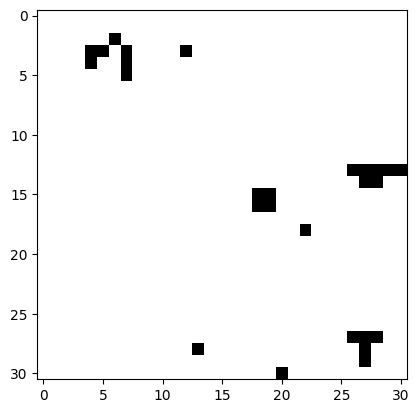

161it [01:08,  2.92it/s]

88.04642057418823 0.5502901285886764


171it [01:11,  3.64it/s]

93.74113258719444 0.5514184269834967


181it [01:14,  3.58it/s]

99.17828914523125 0.5509904952512847


191it [01:17,  3.65it/s]

104.91966035962105 0.5522087387348477


200it [01:19,  3.61it/s]

111.27011135220528 0.5563505567610264
111.27011135220528 0.5563505567610264


100%|██████████| 31/31 [00:08<00:00,  3.75it/s]


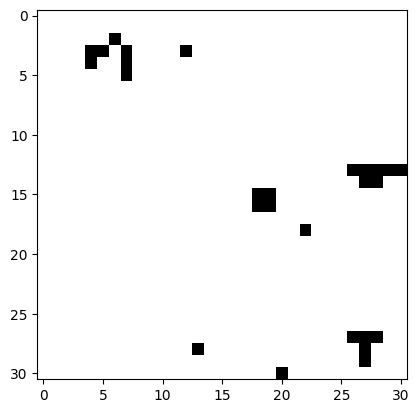

211it [01:31,  2.84it/s]

116.46075874567032 0.5545750416460491


221it [01:33,  3.50it/s]

122.40282833576202 0.556376492435282


231it [01:36,  3.59it/s]

127.31879779696465 0.5535599904215854


241it [01:39,  3.67it/s]

132.8319911956787 0.5534666299819946


245it [01:40,  2.43it/s]
 30%|███       | 3/10 [09:48<22:54, 196.30s/it]


KeyboardInterrupt: 

In [42]:
## Define gradient clipping value
from tqdm import tqdm

previous_loss = 1e9
cur_loss = 1e9
steps_without_improv = 0
model.train()
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0.0

    for idx, (batch_tiles, batch_labels, _) in tqdm(enumerate(dataloader), position=0, leave=True):
        # Move the data to GPU
        batch_labels = batch_labels.float().cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
        outputs = outputs.to(device)
        batch_tiles = batch_tiles.to(device)
        outputs = model(outputs)
        # Calculate loss
        loss = criterion(outputs, batch_labels)
        # Scale the loss, compute gradients
        loss.backward()
        optimizer.step()

        # Track running loss for the epoch
        running_loss += loss.item()
        if idx% 10 == 0 and idx > 0:
             print(running_loss, running_loss/idx)
        if idx % 50 == 0 and idx != 0:
            print(running_loss, running_loss/idx)
            if running_loss/idx < 0.05:
                print(f"Final loss {running_loss/len(dataloader)}")
                break
            with torch.no_grad():
                ans = []
                for batch_tiles, batch_labels, corners in tqdm(valid_dataloader, position=0, leave=True):
                    batch_labels = batch_labels.float().cuda()
                
                
                    outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
                    outputs = outputs.to(device)
                    batch_tiles = batch_tiles.to(device)
                    outputs = model(outputs)
                    predictions = torch.sigmoid(outputs)
                    ans.extend(predictions.squeeze(1).cpu().detach().numpy() >= 0.5)
                    # print(len(ans))
                plt.imshow(np.array(ans).reshape(31, 31), cmap = "gray")
                plt.show()
                    

    # Scheduler step
    scheduler.step()

    cur_loss = running_loss/len(dataloader)
    if cur_loss < previous_loss:
        steps_without_improv = 0
        previous_loss = cur_loss
    else:
        steps_without_improv += 1


    if running_loss/len(dataloader) < 0.05 or steps_without_improv >= 2:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")


In [41]:
torch.save(model.state_dict(), '/kaggle/working/my_model_weights_big.pth')

In [18]:
# made smaller tile_size
tile_size = 16  # Size of the tile in the YX dimension
stride = 16  # Stride for moving the tile in the YX dimension
batch_size = 32
z_depth = 10 # thickness of the tile
# Create the dataset
#dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
#valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0].max(axis = 0)[np.newaxis,...], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0].max(axis = 0)[np.newaxis,...], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)
# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

9504
433


In [22]:
z, y, x = 1, 16, 16
z_step = 1
scales = [2,4,6,8]

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FractalNet(z, y, x, z_step, scales).to(device)
initialize_weights(model)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
NUM_EPOCHS = 10
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

11it [00:08,  1.28it/s]00:00<?, ?it/s]

7.402207612991333 0.7402207612991333


21it [00:15,  1.32it/s]

14.11028677225113 0.7055143386125564


31it [00:23,  1.32it/s]

20.786182820796967 0.6928727606932322


41it [00:31,  1.32it/s]

26.996092438697815 0.6749023109674454


50it [00:38,  1.27it/s]

33.25708711147308 0.6651417422294617
33.25708711147308 0.6651417422294617


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


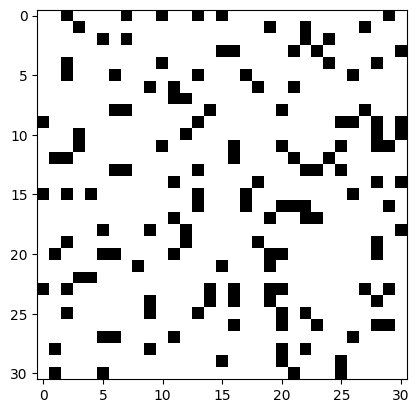

61it [01:09,  1.05it/s]

39.137514650821686 0.6522919108470281


71it [01:16,  1.33it/s]

45.06707036495209 0.6438152909278869


81it [01:24,  1.33it/s]

51.142090141773224 0.6392761267721653


91it [01:31,  1.36it/s]

57.08694535493851 0.6342993928326501


100it [01:38,  1.33it/s]

62.70688605308533 0.6270688605308533
62.70688605308533 0.6270688605308533


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


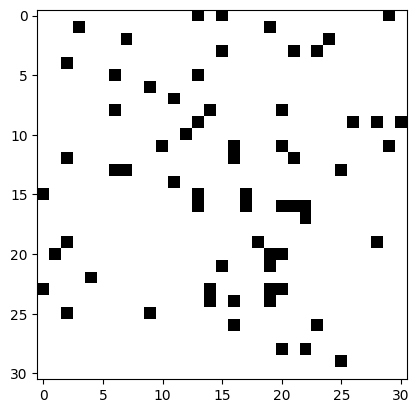

111it [02:09,  1.06it/s]

68.43992233276367 0.6221811121160333


121it [02:16,  1.32it/s]

73.89195311069489 0.6157662759224574


131it [02:24,  1.33it/s]

79.70457166433334 0.6131120897256411


141it [02:31,  1.32it/s]

85.56909555196762 0.6112078253711973


150it [02:38,  1.35it/s]

90.76266196370125 0.6050844130913416
90.76266196370125 0.6050844130913416


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


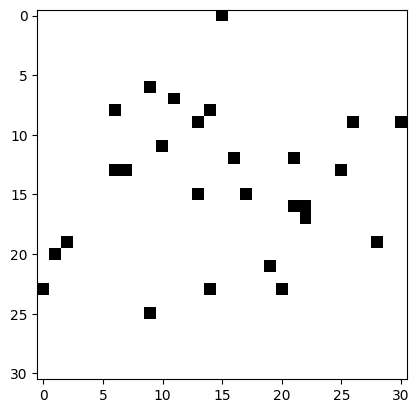

161it [03:09,  1.06it/s]

96.69197791814804 0.6043248619884253


171it [03:17,  1.28it/s]

102.34016224741936 0.6020009543965844


181it [03:24,  1.33it/s]

108.36429172754288 0.6020238429307938


191it [03:32,  1.33it/s]

113.80422866344452 0.5989696245444448


200it [03:38,  1.34it/s]

119.52974691987038 0.5976487345993519
119.52974691987038 0.5976487345993519


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


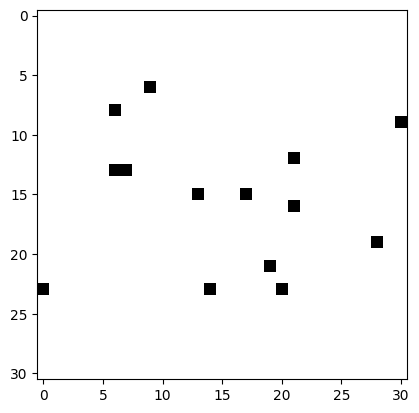

211it [04:09,  1.07it/s]

124.55049577355385 0.593097598921685


221it [04:17,  1.33it/s]

130.15703377127647 0.5916228807785294


231it [04:24,  1.31it/s]

135.31062403321266 0.5883070610139681


241it [04:32,  1.35it/s]

140.76385116577148 0.5865160465240479


250it [04:39,  1.34it/s]

146.45114529132843 0.5858045811653138
146.45114529132843 0.5858045811653138


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


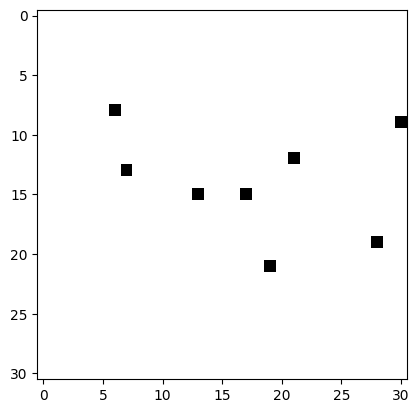

261it [05:10,  1.06it/s]

152.5230301618576 0.5866270390840677


271it [05:17,  1.33it/s]

158.0743923485279 0.5854607124019552


281it [05:25,  1.30it/s]

163.6427602171898 0.5844384293471064


291it [05:32,  1.35it/s]

169.09372201561928 0.5830818000538596


300it [05:39,  1.31it/s]

174.58252656459808 0.581941755215327
174.58252656459808 0.581941755215327


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


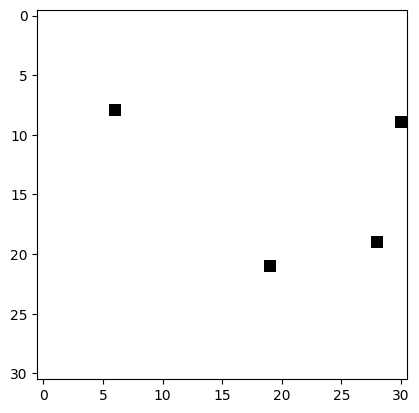

311it [06:10,  1.07it/s]

180.42536211013794 0.5820172971294773


321it [06:17,  1.33it/s]

185.8481807410717 0.580775564815849


331it [06:25,  1.32it/s]

191.14138209819794 0.5792163093884786


341it [06:33,  1.34it/s]

196.71090298891068 0.578561479379149


350it [06:39,  1.32it/s]

201.83239391446114 0.5766639826127461
201.83239391446114 0.5766639826127461


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


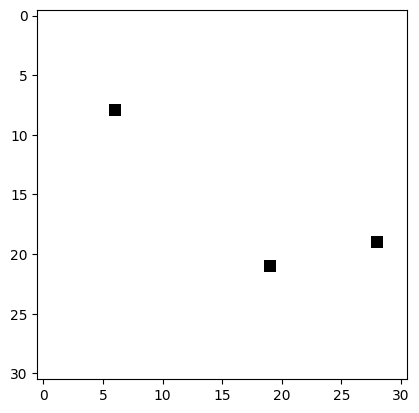

361it [07:10,  1.05it/s]

207.03028425574303 0.5750841229326196


371it [07:18,  1.33it/s]

212.7200335264206 0.5749190095308665


381it [07:25,  1.33it/s]

218.48335045576096 0.5749561854098972


384it [07:27,  1.17s/it]
11it [00:08,  1.32it/s]07:27<1:07:10, 447.85s/it]

5.003532320261002 0.5003532320261002


21it [00:15,  1.30it/s]

10.64107996225357 0.5320539981126785


31it [00:23,  1.35it/s]

16.071014672517776 0.5357004890839259


41it [00:30,  1.34it/s]

21.577749609947205 0.5394437402486801


50it [00:37,  1.30it/s]

26.959815204143524 0.5391963040828704
26.959815204143524 0.5391963040828704


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


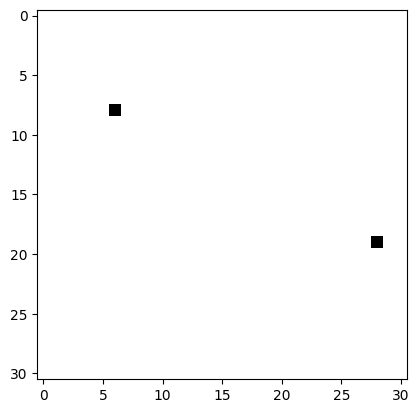

61it [01:08,  1.02it/s]

32.26694771647453 0.5377824619412422


71it [01:16,  1.31it/s]

37.3039265871048 0.53291323695864


81it [01:23,  1.32it/s]

42.632568418979645 0.5329071052372456


91it [01:31,  1.34it/s]

48.2491560280323 0.5361017336448034


100it [01:38,  1.32it/s]

54.03416934609413 0.5403416934609413
54.03416934609413 0.5403416934609413


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


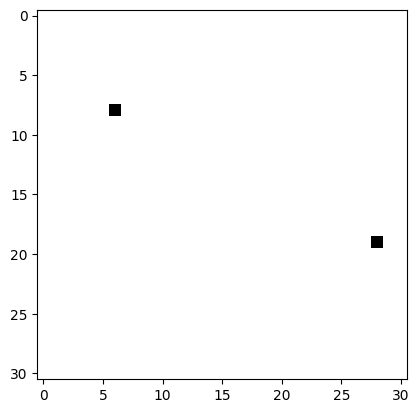

111it [02:08,  1.04it/s]

59.28902390599251 0.5389911264181138


121it [02:16,  1.32it/s]

65.10662880539894 0.5425552400449912


131it [02:24,  1.33it/s]

70.84485960006714 0.5449604584620549


141it [02:31,  1.34it/s]

76.1433054804802 0.5438807534320014


150it [02:38,  1.34it/s]

81.47961696982384 0.5431974464654923
81.47961696982384 0.5431974464654923


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


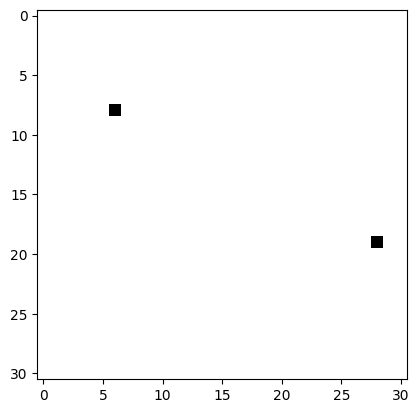

161it [03:09,  1.06it/s]

87.00923416018486 0.5438077135011554


171it [03:17,  1.32it/s]

92.44313383102417 0.5437831401824951


181it [03:24,  1.29it/s]

98.203364610672 0.5455742478370667


191it [03:32,  1.34it/s]

104.13595774769783 0.5480839881457781


200it [03:39,  1.32it/s]

109.29873076081276 0.5464936538040638
109.29873076081276 0.5464936538040638


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


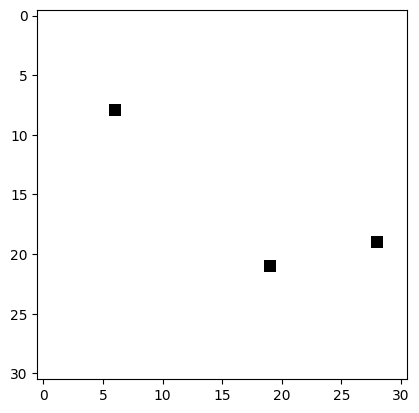

211it [04:10,  1.07it/s]

114.73658889532089 0.5463647090253376


221it [04:17,  1.28it/s]

120.27289971709251 0.5466949987140569


231it [04:25,  1.30it/s]

126.25015750527382 0.5489137282837993


241it [04:33,  1.29it/s]

131.78177866339684 0.5490907444308202


250it [04:39,  1.34it/s]

137.22723323106766 0.5489089329242707
137.22723323106766 0.5489089329242707


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


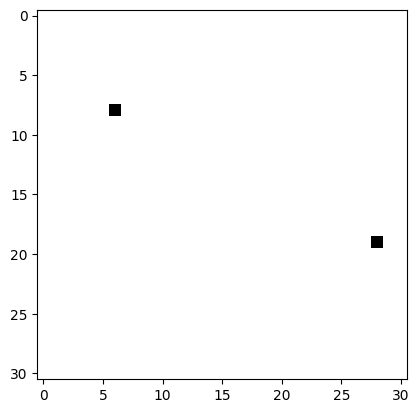

261it [05:10,  1.06it/s]

142.2777283489704 0.5472220321114246


271it [05:18,  1.32it/s]

148.10822814702988 0.5485489931371477


281it [05:25,  1.30it/s]

153.96423771977425 0.5498722775706223


291it [05:33,  1.31it/s]

159.2259614765644 0.54905503957436


300it [05:40,  1.31it/s]

164.1382193863392 0.547127397954464
164.1382193863392 0.547127397954464


100%|██████████| 31/31 [00:23<00:00,  1.35it/s]


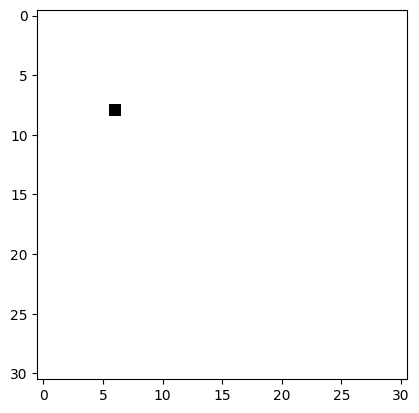

311it [06:11,  1.07it/s]

169.04272815585136 0.5452991230833915


321it [06:19,  1.30it/s]

174.57173922657967 0.5455366850830614


331it [06:26,  1.31it/s]

180.19391790032387 0.5460421754555269


341it [06:34,  1.34it/s]

185.90870609879494 0.5467903120552793


350it [06:41,  1.33it/s]

191.3187728524208 0.5466250652926309
191.3187728524208 0.5466250652926309


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


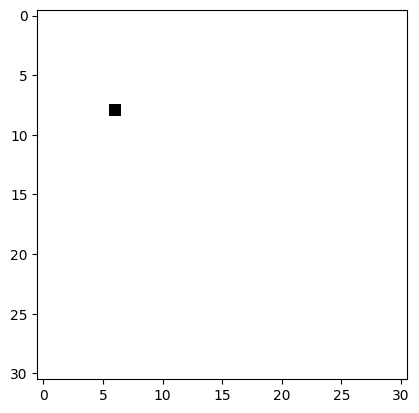

361it [07:12,  1.06it/s]

196.71422308683395 0.5464283974634276


371it [07:19,  1.30it/s]

202.27173879742622 0.546680375128179


381it [07:27,  1.33it/s]

207.7932136952877 0.5468242465665466


384it [07:28,  1.17s/it]
11it [00:08,  1.33it/s]14:56<59:48, 448.52s/it]  

5.989725589752197 0.5989725589752197


21it [00:15,  1.33it/s]

11.416845351457596 0.5708422675728798


31it [00:23,  1.33it/s]

16.82046338915825 0.5606821129719416


41it [00:30,  1.31it/s]

22.005131274461746 0.5501282818615436


50it [00:37,  1.32it/s]

27.719016134738922 0.5543803226947784
27.719016134738922 0.5543803226947784


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


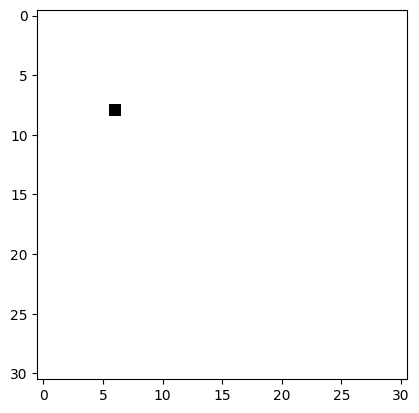

61it [01:08,  1.06it/s]

33.31855493783951 0.5553092489639918


71it [01:16,  1.31it/s]

38.160913944244385 0.5451559134892054


81it [01:23,  1.34it/s]

43.70095682144165 0.5462619602680207


91it [01:31,  1.33it/s]

49.11334279179573 0.5457038087977304


100it [01:38,  1.32it/s]

54.90374740958214 0.5490374740958214
54.90374740958214 0.5490374740958214


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


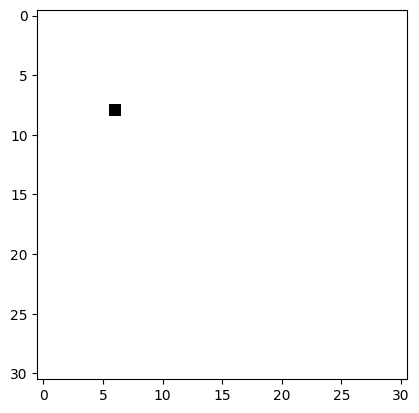

111it [02:09,  1.06it/s]

60.66890177130699 0.5515354706482454


121it [02:17,  1.31it/s]

65.90361911058426 0.5491968259215355


131it [02:24,  1.33it/s]

71.44293165206909 0.5495610127082238


141it [02:32,  1.34it/s]

76.25213143229485 0.5446580816592489


150it [02:38,  1.29it/s]

81.40960684418678 0.5427307122945786
81.40960684418678 0.5427307122945786


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


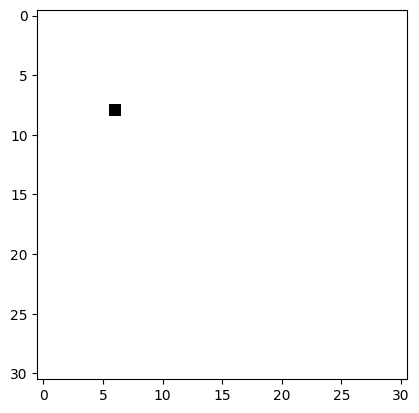

161it [03:09,  1.05it/s]

86.43381369113922 0.5402113355696201


171it [03:17,  1.28it/s]

91.54550039768219 0.5385029435157775


181it [03:25,  1.31it/s]

96.9629200398922 0.5386828891105122


191it [03:32,  1.33it/s]

102.33164778351784 0.5385876199132518


200it [03:39,  1.34it/s]

107.77740269899368 0.5388870134949684
107.77740269899368 0.5388870134949684


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


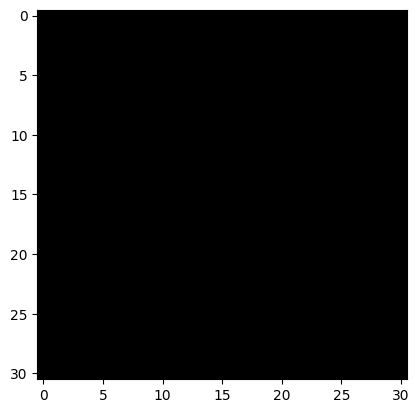

211it [04:10,  1.07it/s]

113.32214346528053 0.539629254596574


221it [04:17,  1.31it/s]

118.76372143626213 0.5398350974375551


231it [04:25,  1.33it/s]

124.80496004223824 0.5426302610532098


241it [04:32,  1.35it/s]

130.15520375967026 0.542313348998626


250it [04:39,  1.35it/s]

135.31141883134842 0.5412456753253937
135.31141883134842 0.5412456753253937


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


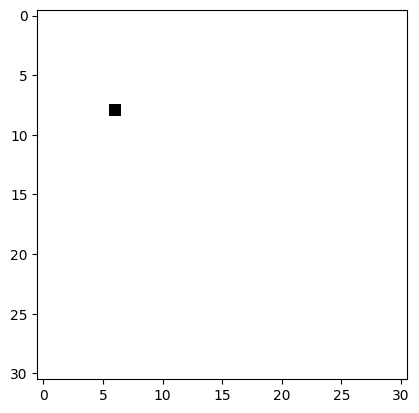

261it [05:10,  1.06it/s]

141.30133187770844 0.5434666610681094


271it [05:18,  1.29it/s]

146.35944333672523 0.5420720123582417


281it [05:25,  1.33it/s]

151.8959588110447 0.5424855671823025


291it [05:33,  1.29it/s]

157.99759697914124 0.5448192999280732


300it [05:40,  1.33it/s]

163.39479342103004 0.5446493114034335
163.39479342103004 0.5446493114034335


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


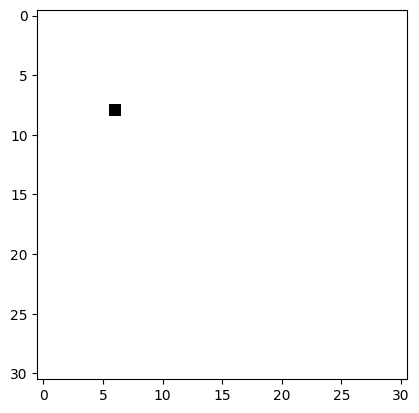

311it [06:11,  1.07it/s]

168.74962055683136 0.544353614699456


321it [06:18,  1.32it/s]

174.4662466943264 0.54520702091977


331it [06:26,  1.31it/s]

179.90737596154213 0.5451738665501277


341it [06:34,  1.34it/s]

184.87679281830788 0.5437552729950231


350it [06:40,  1.32it/s]

190.09324395656586 0.5431235541616167
190.09324395656586 0.5431235541616167


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


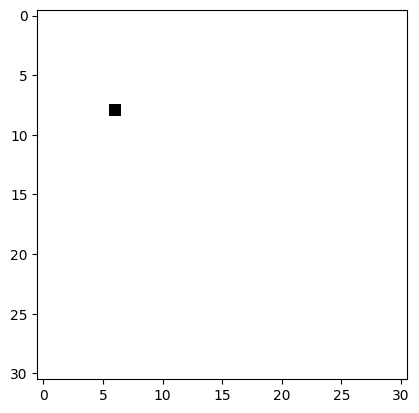

361it [07:11,  1.04it/s]

195.42917707562447 0.542858825210068


371it [07:19,  1.32it/s]

201.09056985378265 0.543488026631845


381it [07:27,  1.31it/s]

206.70030212402344 0.5439481634842722


384it [07:28,  1.17s/it]
11it [00:08,  1.33it/s]22:25<52:21, 448.72s/it]

5.590620934963226 0.5590620934963226


21it [00:15,  1.32it/s]

10.750103682279587 0.5375051841139793


31it [00:23,  1.32it/s]

15.771906971931458 0.5257302323977152


41it [00:31,  1.32it/s]

21.345470517873764 0.5336367629468441


50it [00:37,  1.31it/s]

26.371464014053345 0.527429280281067
26.371464014053345 0.527429280281067


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


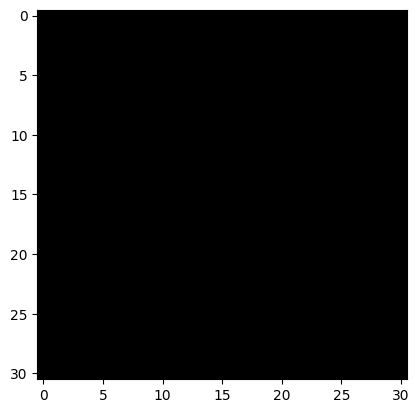

61it [01:09,  1.06it/s]

32.035926550626755 0.5339321091771125


71it [01:16,  1.33it/s]

37.38185691833496 0.5340265274047852


81it [01:24,  1.30it/s]

43.039819329977036 0.5379977416247129


91it [01:31,  1.31it/s]

48.71513241529465 0.5412792490588294


100it [01:38,  1.30it/s]

53.840778321027756 0.5384077832102776
53.840778321027756 0.5384077832102776


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


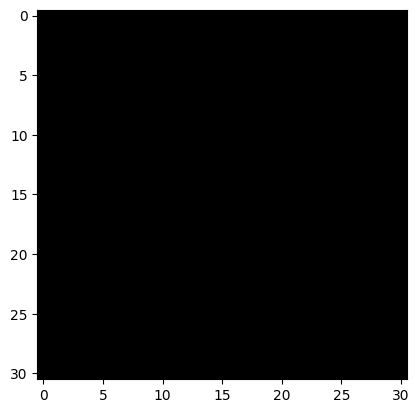

111it [02:09,  1.04it/s]

59.276220202445984 0.5388747291131453


121it [02:17,  1.33it/s]

65.3872258067131 0.5448935483892758


131it [02:24,  1.34it/s]

70.32338911294937 0.5409491470226875


141it [02:32,  1.31it/s]

75.62265992164612 0.5401618565831866


150it [02:39,  1.32it/s]

81.18276888132095 0.5412184592088064
81.18276888132095 0.5412184592088064


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


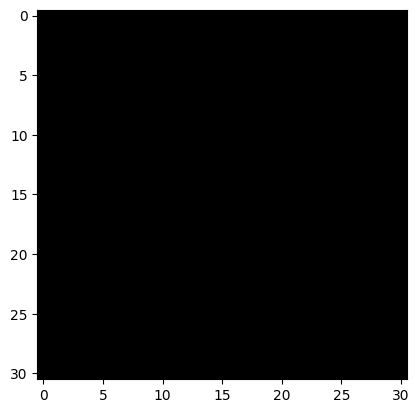

161it [03:10,  1.04it/s]

86.58665633201599 0.5411666020750999


171it [03:18,  1.32it/s]

92.24950703978539 0.5426441590575611


181it [03:25,  1.29it/s]

97.52424415946007 0.5418013564414448


191it [03:33,  1.34it/s]

102.48785498738289 0.5394097630914889


200it [03:40,  1.32it/s]

108.25031527876854 0.5412515763938427
108.25031527876854 0.5412515763938427


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


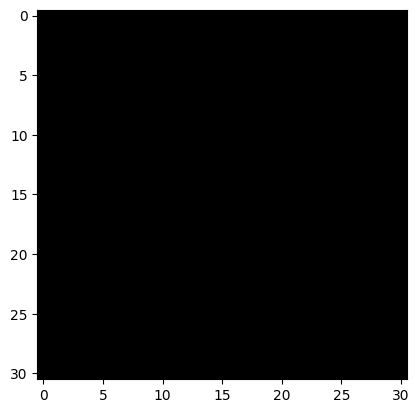

211it [04:11,  1.05it/s]

113.4475921690464 0.5402266293764114


221it [04:18,  1.31it/s]

118.89707571268082 0.5404412532394582


231it [04:26,  1.32it/s]

124.93968829512596 0.5432160360657651


236it [04:30,  1.15s/it]
 30%|███       | 3/10 [26:56<1:02:51, 538.79s/it]


KeyboardInterrupt: 

In [27]:
## Define gradient clipping value
from tqdm import tqdm

previous_loss = 1e9
cur_loss = 1e9
steps_without_improv = 0
model.train()
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0.0

    for idx, (batch_tiles, batch_labels, _) in tqdm(enumerate(dataloader), position=0, leave=True):
        # Move the data to GPU
        batch_labels = batch_labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
        outputs = outputs.to(device)
        batch_tiles = batch_tiles.to(device)
        outputs = model(outputs)
        # Calculate loss
        loss = criterion(outputs, batch_labels)
        # Scale the loss, compute gradients
        loss.backward()
        optimizer.step()

        # Track running loss for the epoch
        running_loss += loss.item()
        if idx% 10 == 0 and idx > 0:
             print(running_loss, running_loss/idx)
        if idx % 50 == 0 and idx != 0:
            print(running_loss, running_loss/idx)
            if running_loss/idx < 0.05:
                print(f"Final loss {running_loss/len(dataloader)}")
                break
            with torch.no_grad():
                ans = []
                for batch_tiles, batch_labels, corners in tqdm(valid_dataloader, position=0, leave=True):
                    batch_labels = batch_labels.float().to(device)
                
                
                    outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
                    outputs = outputs.to(device)
                    batch_tiles = batch_tiles.to(device)
                    outputs = model(outputs)
                    predictions = torch.sigmoid(outputs)
                    ans.extend(predictions.squeeze(1).cpu().detach().numpy() >= 0.5)
                    # print(len(ans))
                plt.imshow(np.array(ans).reshape(31, 31), cmap = "gray")
                plt.show()
                    

    # Scheduler step
    scheduler.step()

    cur_loss = running_loss/len(dataloader)
    if cur_loss < previous_loss:
        steps_without_improv = 0
        previous_loss = cur_loss
    else:
        steps_without_improv += 1


    if running_loss/len(dataloader) < 0.05 or steps_without_improv >= 2:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")


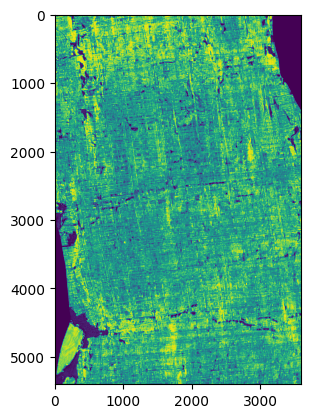

In [35]:
plt.imshow(segment[26:26+z_depth,200:5600,1000:4600,0].max(axis=0))

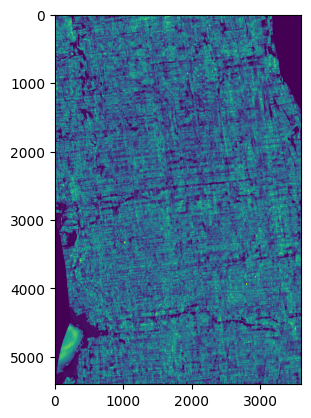

In [33]:
plt.imshow(segment[26:26+z_depth,200:5600,1000:4600,0].mean(axis=0))

Сходимость чуть лучше -> вероятно несколько слоев полезны.

In [36]:
# made smaller tile_size
tile_size = 16  # Size of the tile in the YX dimension
stride = 16  # Stride for moving the tile in the YX dimension
batch_size = 32
z_depth = 10 # thickness of the tile
# Create the dataset
#dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
#valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0].mean(axis = 0)[np.newaxis,...], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0].mean(axis = 0)[np.newaxis,...], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)
# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

9504
433


In [37]:
z, y, x = 1, 16, 16
z_step = 1
scales = [2,4,6,8]

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FractalNet(z, y, x, z_step, scales).to(device)
initialize_weights(model)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
NUM_EPOCHS = 10
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

11it [00:08,  1.31it/s]00:00<?, ?it/s]

10.212484002113342 1.0212484002113342


21it [00:15,  1.36it/s]

18.980977773666382 0.949048888683319


31it [00:23,  1.31it/s]

27.62569785118103 0.9208565950393677


41it [00:30,  1.30it/s]

34.8935170173645 0.8723379254341126


50it [00:37,  1.33it/s]

42.957032799720764 0.8591406559944152
42.957032799720764 0.8591406559944152


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


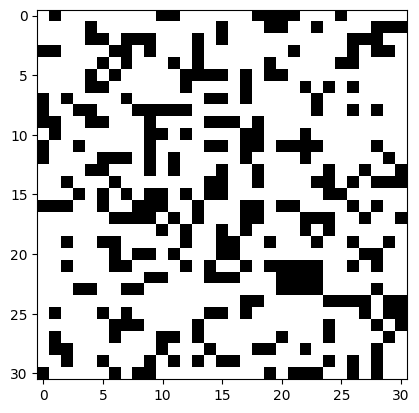

61it [01:08,  1.05it/s]

49.927578806877136 0.8321263134479523


71it [01:16,  1.28it/s]

56.39503675699234 0.8056433822427477


81it [01:24,  1.31it/s]

63.65945214033127 0.7957431517541409


91it [01:31,  1.30it/s]

69.91047930717468 0.776783103413052


100it [01:38,  1.30it/s]

76.49374184012413 0.7649374184012413
76.49374184012413 0.7649374184012413


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


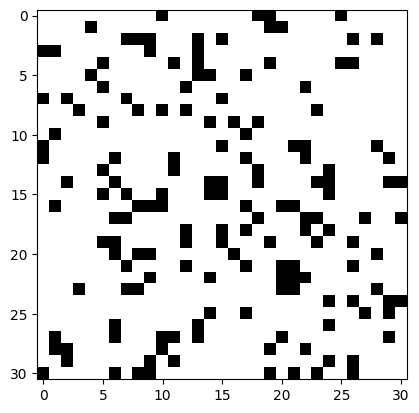

111it [02:10,  1.04it/s]

83.18752583861351 0.7562502348964865


121it [02:17,  1.25it/s]

89.35113522410393 0.7445927935341994


131it [02:25,  1.33it/s]

95.59046891331673 0.7353112993332056


141it [02:32,  1.34it/s]

102.07274731993675 0.7290910522852625


150it [02:39,  1.30it/s]

108.247025847435 0.7216468389828999
108.247025847435 0.7216468389828999


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


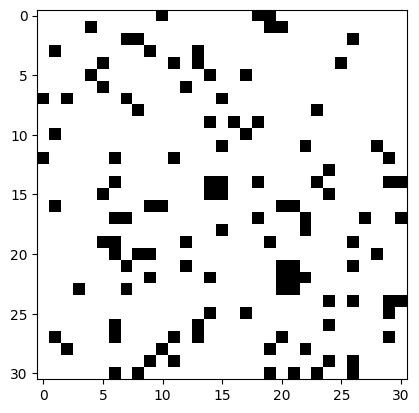

161it [03:11,  1.03it/s]

114.67522168159485 0.7167201355099678


171it [03:19,  1.26it/s]

120.97657364606857 0.7116269038004034


181it [03:27,  1.29it/s]

127.11883330345154 0.7062157405747308


191it [03:34,  1.29it/s]

133.50743025541306 0.7026706855548056


200it [03:41,  1.29it/s]

139.82701671123505 0.6991350835561753
139.82701671123505 0.6991350835561753


100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


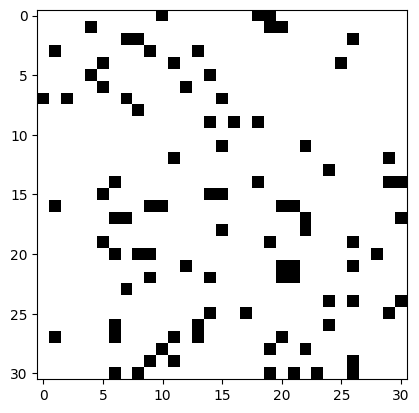

211it [04:14,  1.05it/s]

145.68508571386337 0.6937385033993494


221it [04:22,  1.30it/s]

151.2650709450245 0.6875685042955658


231it [04:30,  1.30it/s]

157.2013397216797 0.6834840857464334


241it [04:37,  1.31it/s]

163.3999244570732 0.6808330185711384


250it [04:44,  1.27it/s]

168.91394305229187 0.6756557722091675
168.91394305229187 0.6756557722091675


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


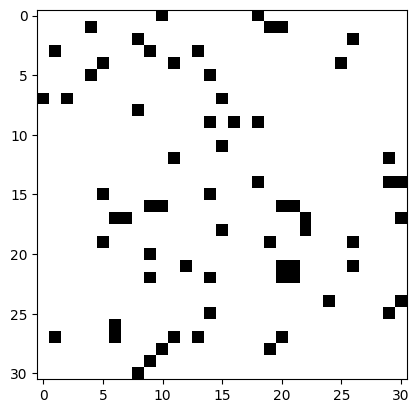

261it [05:15,  1.04it/s]

174.7506323158741 0.6721178165995157


271it [05:23,  1.32it/s]

180.89725145697594 0.6699898202110219


281it [05:31,  1.33it/s]

186.18051809072495 0.6649304217525891


291it [05:38,  1.33it/s]

192.48977380990982 0.6637578407238269


300it [05:45,  1.34it/s]

197.55614483356476 0.6585204827785492
197.55614483356476 0.6585204827785492


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


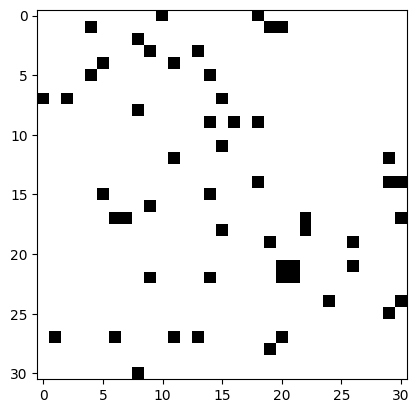

311it [06:16,  1.02it/s]

203.8797446489334 0.6576765956417207


321it [06:24,  1.33it/s]

209.6629627943039 0.6551967587321996


331it [06:31,  1.33it/s]

215.33054518699646 0.652516803596959


341it [06:39,  1.31it/s]

220.9139216542244 0.6497468283947776


350it [06:46,  1.35it/s]

227.0235511660576 0.6486387176173074
227.0235511660576 0.6486387176173074


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


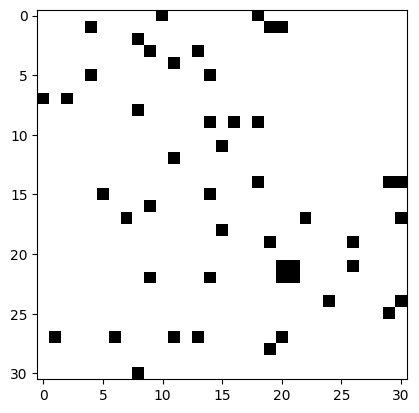

361it [07:17,  1.06it/s]

232.97013494372368 0.6471392637325658


371it [07:24,  1.23it/s]

238.76899003982544 0.6453215947022309


381it [07:32,  1.34it/s]

244.29427054524422 0.64287965932959


384it [07:34,  1.18s/it]
11it [00:08,  1.34it/s]07:34<1:08:09, 454.36s/it]

6.37016624212265 0.637016624212265


21it [00:15,  1.33it/s]

12.387500584125519 0.619375029206276


31it [00:23,  1.30it/s]

18.29021719098091 0.6096739063660304


41it [00:30,  1.35it/s]

23.64949119091034 0.5912372797727585


50it [00:37,  1.32it/s]

29.21047380566597 0.5842094761133194
29.21047380566597 0.5842094761133194


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


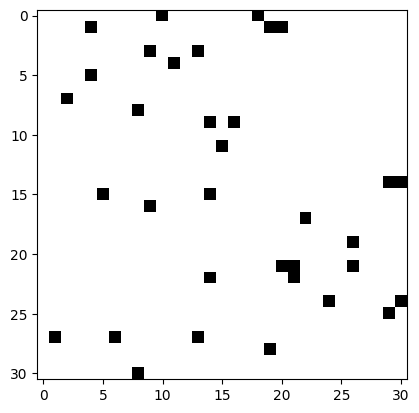

61it [01:08,  1.06it/s]

35.25573539733887 0.5875955899556478


71it [01:16,  1.30it/s]

40.79404565691948 0.5827720808131355


81it [01:24,  1.30it/s]

46.383344143629074 0.5797918017953634


91it [01:31,  1.33it/s]

51.897332191467285 0.5766370243496365


100it [01:38,  1.33it/s]

56.83356696367264 0.5683356696367263
56.83356696367264 0.5683356696367263


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


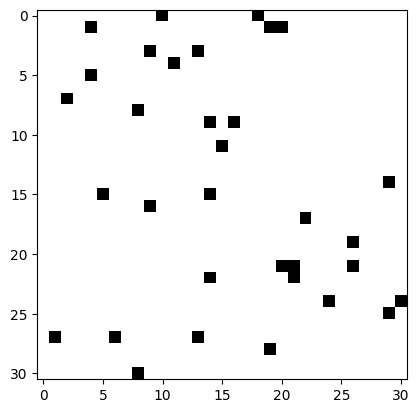

111it [02:09,  1.06it/s]

62.618214666843414 0.5692564969713038


121it [02:17,  1.32it/s]

68.4564701616764 0.5704705846806367


131it [02:25,  1.29it/s]

74.27832955121994 0.5713717657786149


141it [02:32,  1.32it/s]

80.32942685484886 0.5737816203917776


150it [02:39,  1.34it/s]

85.76862558722496 0.5717908372481664
85.76862558722496 0.5717908372481664


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


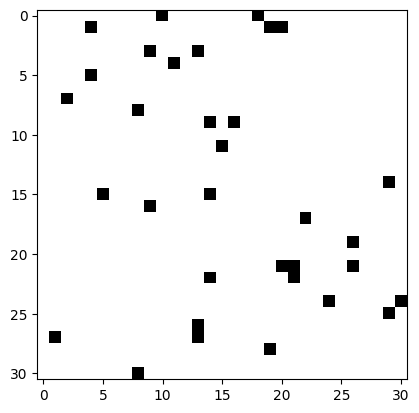

161it [03:10,  1.05it/s]

91.48934316635132 0.5718083947896957


171it [03:18,  1.34it/s]

96.79098716378212 0.5693587480222477


181it [03:25,  1.34it/s]

102.83219078183174 0.5712899487879541


191it [03:33,  1.31it/s]

108.61308133602142 0.5716477965053759


200it [03:40,  1.31it/s]

115.06770160794258 0.5753385080397129
115.06770160794258 0.5753385080397129


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


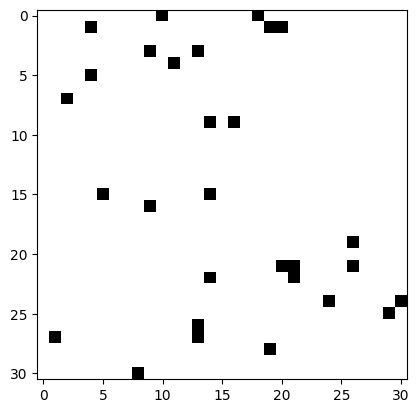

211it [04:11,  1.06it/s]

120.80551812052727 0.5752643720025108


221it [04:19,  1.33it/s]

126.7018513083458 0.5759175059470263


231it [04:26,  1.28it/s]

132.2814840078354 0.5751368869905886


241it [04:34,  1.33it/s]

137.72616031765938 0.5738590013235807


250it [04:41,  1.34it/s]

144.06556951999664 0.5762622780799865
144.06556951999664 0.5762622780799865


100%|██████████| 31/31 [00:22<00:00,  1.39it/s]


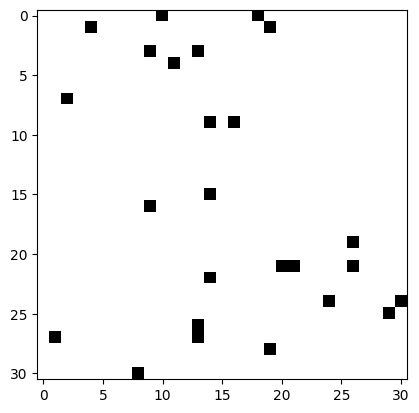

261it [05:11,  1.05it/s]

149.65098455548286 0.5755807098287803


271it [05:19,  1.33it/s]

155.3555157482624 0.5753907990676386


281it [05:26,  1.35it/s]

161.36135265231133 0.5762905451868262


291it [05:34,  1.32it/s]

166.90041908621788 0.5755186865041996


300it [05:41,  1.32it/s]

172.27563604712486 0.5742521201570828
172.27563604712486 0.5742521201570828


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


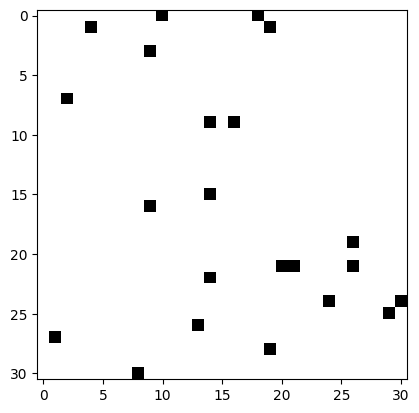

311it [06:12,  1.04it/s]

177.90699902176857 0.5738935452315115


321it [06:19,  1.32it/s]

183.24881893396378 0.5726525591686368


331it [06:27,  1.34it/s]

189.5417131781578 0.5743688278125995


341it [06:34,  1.32it/s]

195.15654289722443 0.5739898320506601


350it [06:41,  1.29it/s]

200.96465215086937 0.5741847204310554
200.96465215086937 0.5741847204310554


100%|██████████| 31/31 [00:22<00:00,  1.39it/s]


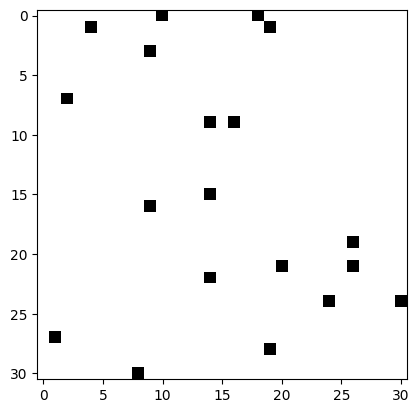

361it [07:12,  1.00it/s]

206.91010102629662 0.5747502806286017


371it [07:20,  1.33it/s]

212.7126441001892 0.5748990381086195


381it [07:28,  1.08it/s]

217.83548936247826 0.5732512877959954


384it [07:31,  1.17s/it]
11it [00:08,  1.33it/s]15:05<1:00:19, 452.39s/it]

6.473838686943054 0.6473838686943054


21it [00:16,  1.30it/s]

12.115730106830597 0.6057865053415299


31it [00:23,  1.33it/s]

18.277187883853912 0.6092395961284638


41it [00:31,  1.33it/s]

23.96767407655716 0.599191851913929


50it [00:38,  1.31it/s]

29.63259893655777 0.5926519787311554
29.63259893655777 0.5926519787311554


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


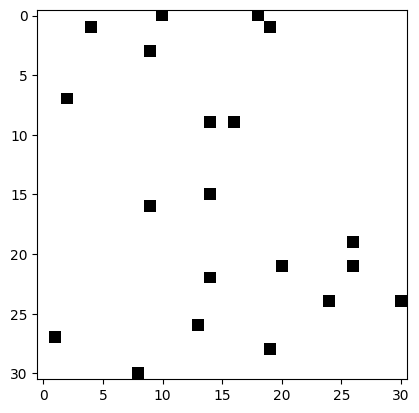

61it [01:09,  1.07it/s]

35.968029886484146 0.5994671647747357


71it [01:17,  1.25it/s]

41.41081419587135 0.5915830599410193


81it [01:24,  1.35it/s]

47.389120280742645 0.5923640035092831


91it [01:32,  1.32it/s]

53.20624831318855 0.5911805368132061


100it [01:39,  1.33it/s]

58.12579965591431 0.5812579965591431
58.12579965591431 0.5812579965591431


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


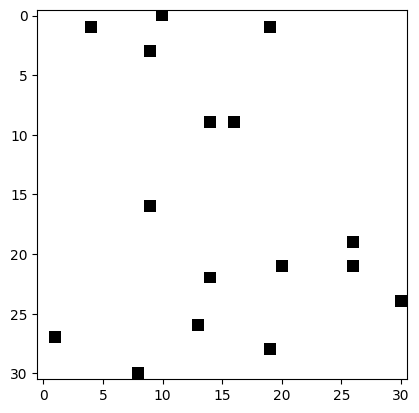

111it [02:09,  1.07it/s]

64.00701740384102 0.5818819763985548


121it [02:17,  1.35it/s]

69.40976092219353 0.5784146743516128


131it [02:25,  1.32it/s]

75.186788469553 0.5783599113042538


141it [02:32,  1.33it/s]

80.4517440199852 0.5746553144284657


150it [02:39,  1.35it/s]

86.10044473409653 0.5740029648939768
86.10044473409653 0.5740029648939768


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


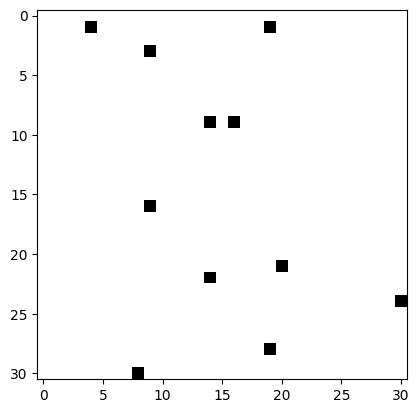

161it [03:10,  1.07it/s]

92.06345546245575 0.5753965966403485


171it [03:17,  1.35it/s]

97.29470604658127 0.5723218002740075


181it [03:25,  1.31it/s]

103.19313177466393 0.5732951765259107


191it [03:32,  1.35it/s]

108.76928597688675 0.5724699261941408


200it [03:39,  1.31it/s]

114.21614053845406 0.5710807026922703
114.21614053845406 0.5710807026922703


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


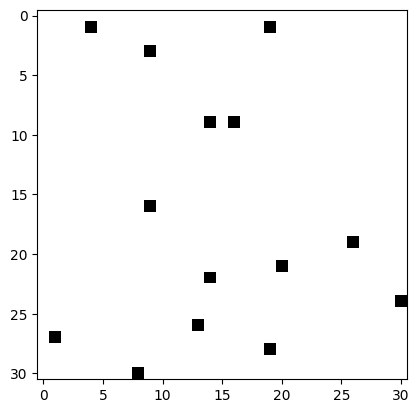

211it [04:10,  1.06it/s]

119.89499291777611 0.5709285377036958


221it [04:17,  1.31it/s]

125.4864462018013 0.570392937280915


231it [04:25,  1.33it/s]

130.98530420660973 0.5695013226374336


241it [04:33,  1.32it/s]

136.43261224031448 0.568469217667977


250it [04:40,  1.32it/s]

142.0607832968235 0.568243133187294
142.0607832968235 0.568243133187294


100%|██████████| 31/31 [00:23<00:00,  1.34it/s]


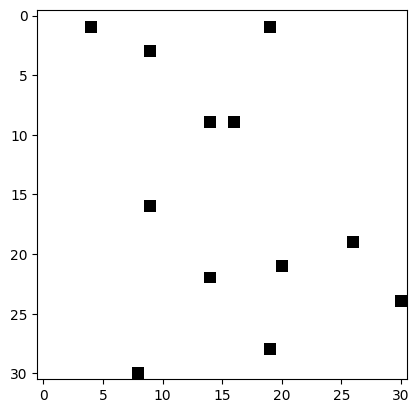

261it [05:11,  1.03it/s]

147.68315535783768 0.5680121359916833


271it [05:19,  1.33it/s]

153.19334807991982 0.5673827706663697


281it [05:26,  1.32it/s]

158.2697672843933 0.5652491688728333


291it [05:34,  1.32it/s]

164.20706295967102 0.5662312515850725


300it [05:41,  1.30it/s]

169.64690339565277 0.5654896779855092
169.64690339565277 0.5654896779855092


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


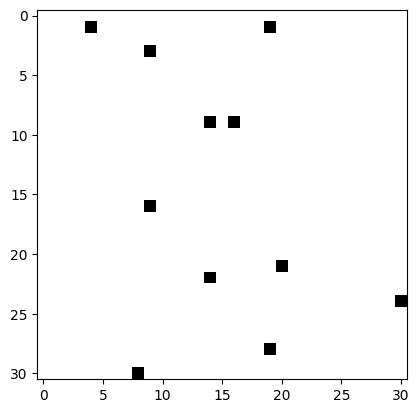

311it [06:12,  1.06it/s]

175.29031577706337 0.5654526315389141


321it [06:20,  1.32it/s]

180.7026050388813 0.564695640746504


331it [06:27,  1.31it/s]

186.50265377759933 0.5651595569018162


341it [06:35,  1.33it/s]

191.53450790047646 0.5633367879425778


350it [06:42,  1.34it/s]

196.40832376480103 0.5611666393280029
196.40832376480103 0.5611666393280029


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


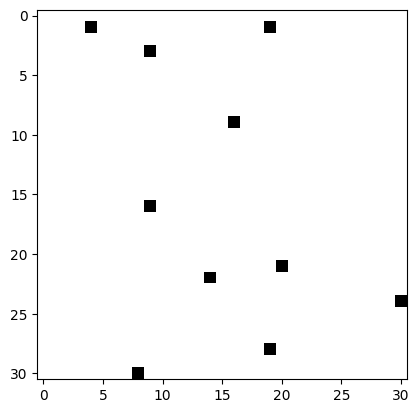

361it [07:13,  1.04it/s]

201.78256031870842 0.5605071119964122


371it [07:20,  1.34it/s]

207.40661188960075 0.5605584105124345


381it [07:28,  1.34it/s]

212.7807803452015 0.5599494219610566


384it [07:30,  1.17s/it]
11it [00:08,  1.32it/s]22:35<52:39, 451.34s/it]  

6.406183749437332 0.6406183749437332


21it [00:15,  1.34it/s]

12.444213777780533 0.6222106888890266


31it [00:23,  1.32it/s]

17.972882241010666 0.5990960747003555


41it [00:31,  1.27it/s]

23.239682853221893 0.5809920713305473


50it [00:38,  1.31it/s]
 30%|███       | 3/10 [23:13<54:11, 464.55s/it]


KeyboardInterrupt: 

In [38]:
## Define gradient clipping value
from tqdm import tqdm

previous_loss = 1e9
cur_loss = 1e9
steps_without_improv = 0
model.train()
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0.0

    for idx, (batch_tiles, batch_labels, _) in tqdm(enumerate(dataloader), position=0, leave=True):
        # Move the data to GPU
        batch_labels = batch_labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
        outputs = outputs.to(device)
        batch_tiles = batch_tiles.to(device)
        outputs = model(outputs)
        # Calculate loss
        loss = criterion(outputs, batch_labels)
        # Scale the loss, compute gradients
        loss.backward()
        optimizer.step()

        # Track running loss for the epoch
        running_loss += loss.item()
        if idx% 10 == 0 and idx > 0:
             print(running_loss, running_loss/idx)
        if idx % 50 == 0 and idx != 0:
            print(running_loss, running_loss/idx)
            if running_loss/idx < 0.05:
                print(f"Final loss {running_loss/len(dataloader)}")
                break
            with torch.no_grad():
                ans = []
                for batch_tiles, batch_labels, corners in tqdm(valid_dataloader, position=0, leave=True):
                    batch_labels = batch_labels.float().to(device)
                
                
                    outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
                    outputs = outputs.to(device)
                    batch_tiles = batch_tiles.to(device)
                    outputs = model(outputs)
                    predictions = torch.sigmoid(outputs)
                    ans.extend(predictions.squeeze(1).cpu().detach().numpy() >= 0.5)
                    # print(len(ans))
                plt.imshow(np.array(ans).reshape(31, 31), cmap = "gray")
                plt.show()
                    

    # Scheduler step
    scheduler.step()

    cur_loss = running_loss/len(dataloader)
    if cur_loss < previous_loss:
        steps_without_improv = 0
        previous_loss = cur_loss
    else:
        steps_without_improv += 1


    if running_loss/len(dataloader) < 0.05 or steps_without_improv >= 2:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")


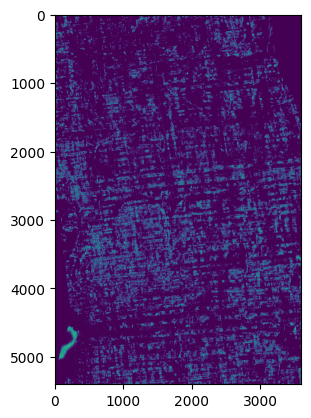

In [39]:
plt.imshow(segment[26:26+z_depth,200:5600,1000:4600,0].min(axis=0))

In [41]:
# made smaller tile_size
tile_size = 16  # Size of the tile in the YX dimension
stride = 16  # Stride for moving the tile in the YX dimension
batch_size = 32
z_depth = 10 # thickness of the tile
# Create the dataset
#dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
#valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0].min(axis = 0)[np.newaxis,...], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0].min(axis = 0)[np.newaxis,...], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)
# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

9504
433


In [42]:
z, y, x = 1, 16, 16
z_step = 1
scales = [2,4,6,8]

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FractalNet(z, y, x, z_step, scales).to(device)
initialize_weights(model)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)
NUM_EPOCHS = 10
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

11it [00:08,  1.34it/s]00:00<?, ?it/s]

7.709031164646149 0.7709031164646148


21it [00:15,  1.30it/s]

14.197613537311554 0.7098806768655777


31it [00:23,  1.32it/s]

20.69743514060974 0.6899145046869913


41it [00:30,  1.36it/s]

27.350401401519775 0.6837600350379944


50it [00:37,  1.34it/s]

33.706440687179565 0.6741288137435913
33.706440687179565 0.6741288137435913


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


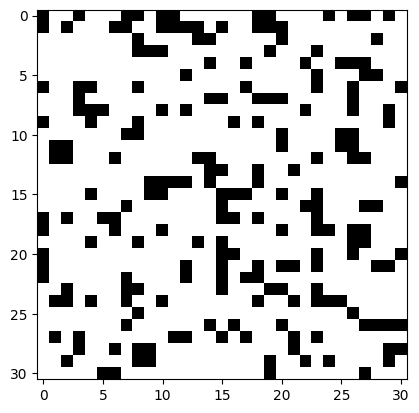

61it [01:08,  1.06it/s]

40.24739354848862 0.6707898924748102


71it [01:16,  1.30it/s]

46.44544953107834 0.6635064218725477


81it [01:23,  1.31it/s]

52.52365788817406 0.6565457236021757


91it [01:31,  1.34it/s]

58.64572796225548 0.6516191995806164


100it [01:38,  1.30it/s]

64.55328240990639 0.6455328240990639
64.55328240990639 0.6455328240990639


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


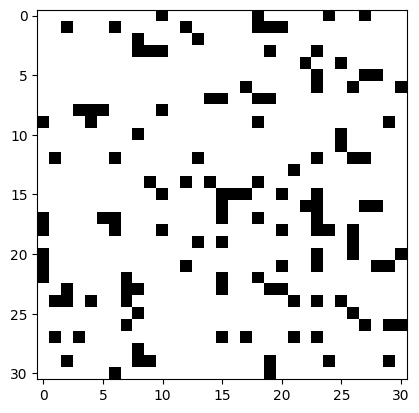

111it [02:09,  1.07it/s]

70.62461647391319 0.6420419679446654


121it [02:16,  1.32it/s]

76.8247344493866 0.640206120411555


131it [02:24,  1.30it/s]

82.75594401359558 0.636584184719966


141it [02:32,  1.32it/s]

88.86566627025604 0.6347547590732574


150it [02:38,  1.32it/s]

94.42491188645363 0.6294994125763576
94.42491188645363 0.6294994125763576


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


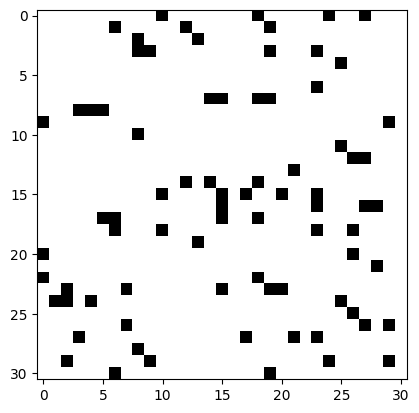

161it [03:10,  1.04it/s]

100.19687786698341 0.6262304866686463


171it [03:17,  1.30it/s]

106.02976849675179 0.6237045205691282


181it [03:25,  1.32it/s]

112.05465352535248 0.6225258529186248


191it [03:32,  1.34it/s]

117.94557684659958 0.6207661939294715


200it [03:39,  1.32it/s]

123.6938933134079 0.6184694665670395
123.6938933134079 0.6184694665670395


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


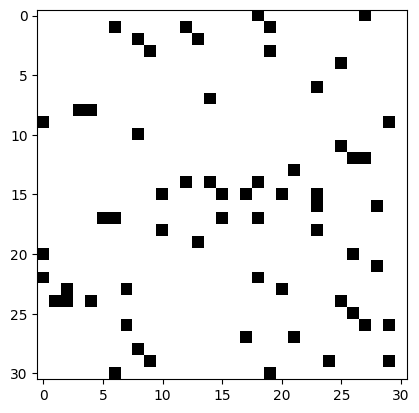

211it [04:10,  1.06it/s]

129.4923845231533 0.6166304024912063


221it [04:18,  1.32it/s]

135.076844394207 0.6139856563373045


231it [04:26,  1.31it/s]

140.8649411201477 0.6124562657397726


241it [04:33,  1.29it/s]

146.8809393942356 0.6120039141426484


250it [04:40,  1.34it/s]

152.75511142611504 0.6110204457044601
152.75511142611504 0.6110204457044601


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


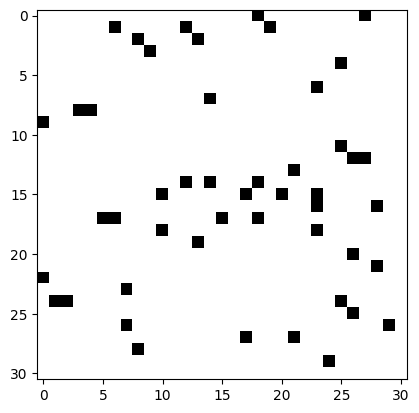

261it [05:11,  1.07it/s]

158.61353343725204 0.6100520516817386


271it [05:19,  1.32it/s]

164.4354522228241 0.6090201934178671


281it [05:26,  1.30it/s]

170.32309380173683 0.6082967635776315


291it [05:34,  1.26it/s]

176.32131758332253 0.6080045433907674


300it [05:41,  1.34it/s]

181.53968474268913 0.6051322824756304
181.53968474268913 0.6051322824756304


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


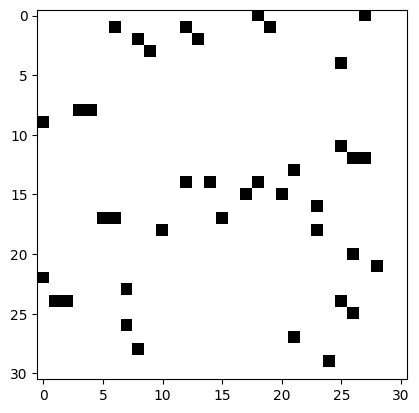

311it [06:12,  1.07it/s]

187.2803035080433 0.6041300113162686


321it [06:19,  1.29it/s]

193.25399014353752 0.6039187191985548


331it [06:27,  1.34it/s]

198.8096829354763 0.6024535846529585


341it [06:34,  1.30it/s]

204.4184329509735 0.6012306851499221


350it [06:41,  1.31it/s]

209.98508962988853 0.5999573989425386
209.98508962988853 0.5999573989425386


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


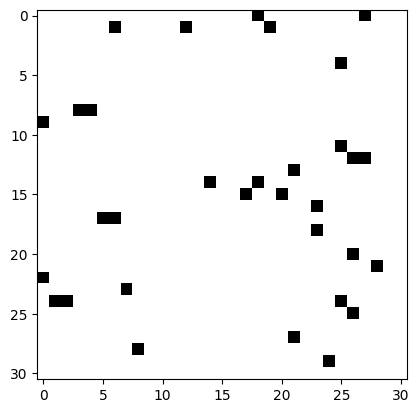

361it [07:12,  1.07it/s]

215.55993714928627 0.5987776031924619


371it [07:20,  1.35it/s]

221.7160209417343 0.5992324890317143


381it [07:27,  1.35it/s]

227.86372169852257 0.5996413728908488


384it [07:29,  1.17s/it]
11it [00:08,  1.34it/s]07:29<1:07:26, 449.56s/it]

5.993869245052338 0.5993869245052338


21it [00:15,  1.34it/s]

11.653877586126328 0.5826938793063163


31it [00:23,  1.27it/s]

17.511654913425446 0.5837218304475148


41it [00:31,  1.32it/s]

23.42679598927498 0.5856698997318744


50it [00:37,  1.35it/s]

29.257491916418076 0.5851498383283615
29.257491916418076 0.5851498383283615


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


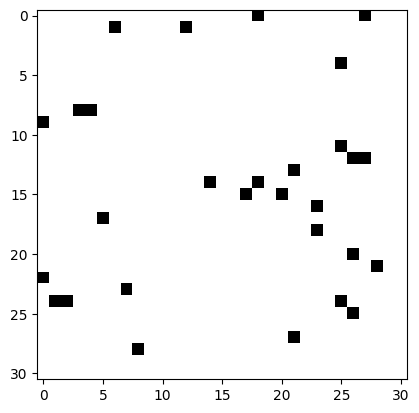

61it [01:09,  1.06it/s]

34.80583158135414 0.580097193022569


71it [01:16,  1.30it/s]

40.52169585227966 0.5788813693182809


81it [01:24,  1.35it/s]

46.66286012530327 0.5832857515662908


91it [01:31,  1.32it/s]

52.240003019571304 0.5804444779952367


100it [01:38,  1.33it/s]

58.40749379992485 0.5840749379992485
58.40749379992485 0.5840749379992485


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


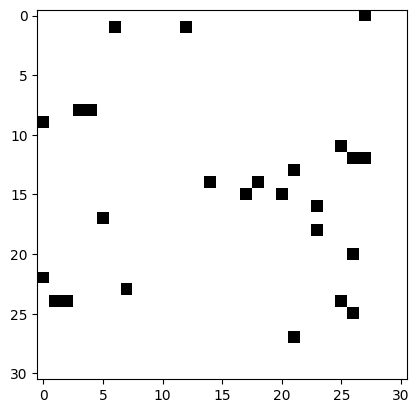

111it [02:09,  1.05it/s]

64.2270051240921 0.5838818647644737


121it [02:17,  1.31it/s]

69.82311245799065 0.5818592704832554


131it [02:24,  1.33it/s]

75.6240145266056 0.581723188666197


141it [02:32,  1.33it/s]

81.54528692364693 0.5824663351689067


150it [02:39,  1.30it/s]

86.97882503271103 0.5798588335514069
86.97882503271103 0.5798588335514069


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


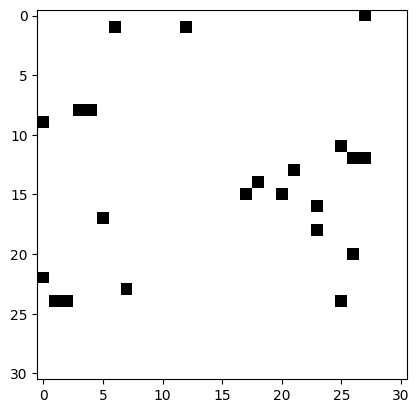

161it [03:10,  1.00it/s]

92.6049494445324 0.5787809340283274


171it [03:18,  1.30it/s]

97.88325670361519 0.5757838629624423


181it [03:25,  1.31it/s]

103.04699295759201 0.5724832942088445


191it [03:33,  1.31it/s]

108.9799288213253 0.5735785727438174


200it [03:40,  1.31it/s]

114.59094643592834 0.5729547321796418
114.59094643592834 0.5729547321796418


100%|██████████| 31/31 [00:23<00:00,  1.34it/s]


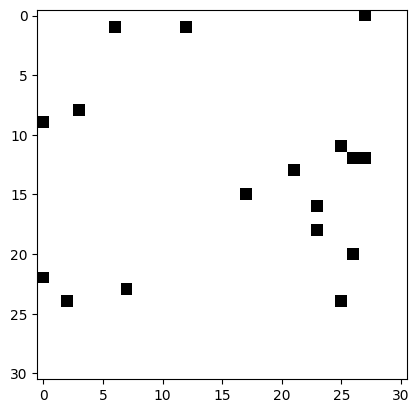

211it [04:11,  1.04it/s]

120.39578580856323 0.573313265755063


221it [04:19,  1.31it/s]

125.9215312898159 0.5723705967718905


231it [04:27,  1.30it/s]

131.60422092676163 0.5721922648989636


241it [04:35,  1.24it/s]

137.3251404762268 0.5721880853176117


250it [04:41,  1.34it/s]

143.66516095399857 0.5746606438159942
143.66516095399857 0.5746606438159942


100%|██████████| 31/31 [00:23<00:00,  1.33it/s]


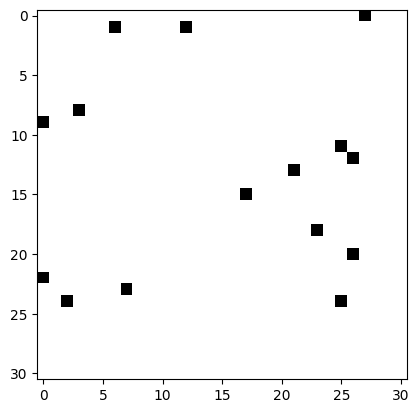

261it [05:13,  1.05it/s]

149.26236191391945 0.5740860073612286


271it [05:21,  1.32it/s]

154.5783929824829 0.5725125666017885


281it [05:29,  1.25it/s]

159.94325304031372 0.5712259037154062


291it [05:36,  1.30it/s]

165.89571645855904 0.5720541946846863


300it [05:43,  1.32it/s]

171.78345894813538 0.5726115298271179
171.78345894813538 0.5726115298271179


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


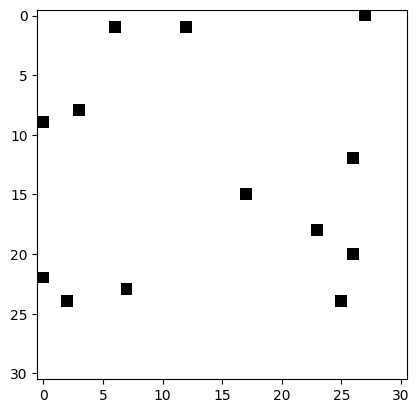

311it [06:14,  1.04it/s]

177.25659582018852 0.571795470387705


321it [06:22,  1.32it/s]

183.2159885764122 0.5725499643012881


331it [06:30,  1.33it/s]

188.7483168542385 0.5719645965279955


341it [06:37,  1.34it/s]

194.53846156597137 0.5721719457822687


350it [06:44,  1.32it/s]

199.75444561243057 0.5707269874640873
199.75444561243057 0.5707269874640873


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


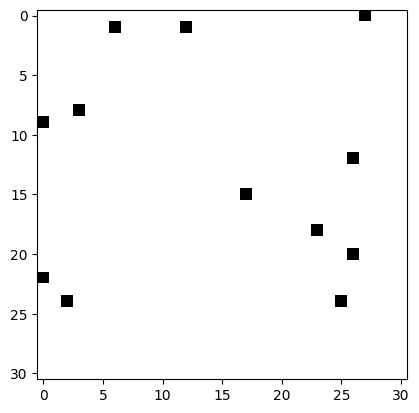

361it [07:15,  1.05it/s]

205.52391436696053 0.5708997621304459


371it [07:22,  1.31it/s]

211.4086627960205 0.5713747643135689


381it [07:30,  1.33it/s]

216.97678330540657 0.5709915350142278


384it [07:32,  1.18s/it]
11it [00:08,  1.31it/s]15:01<1:00:09, 451.23s/it]

5.983081161975861 0.5983081161975861


21it [00:16,  1.32it/s]

11.69194969534874 0.584597484767437


31it [00:23,  1.32it/s]

17.80378618836403 0.5934595396121343


41it [00:31,  1.33it/s]

23.305696099996567 0.5826424024999142


50it [00:38,  1.30it/s]

28.794817835092545 0.5758963567018509
28.794817835092545 0.5758963567018509


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


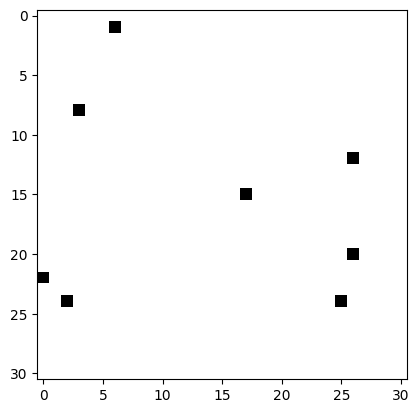

61it [01:09,  1.05it/s]

34.03622114658356 0.5672703524430592


71it [01:16,  1.33it/s]

40.387486070394516 0.5769640867199216


81it [01:24,  1.34it/s]

46.01881346106529 0.5752351682633161


91it [01:31,  1.31it/s]

51.79875108599663 0.5755416787332959


100it [01:38,  1.26it/s]

57.18441092967987 0.5718441092967987
57.18441092967987 0.5718441092967987


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


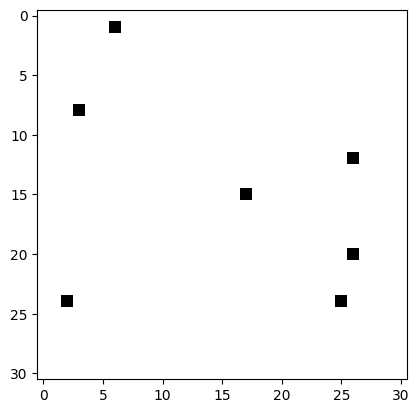

111it [02:10,  1.03it/s]

62.59005123376846 0.5690004657615315


121it [02:17,  1.32it/s]

68.24891129136086 0.5687409274280071


131it [02:25,  1.34it/s]

73.76460289955139 0.5674200223042415


141it [02:32,  1.31it/s]

79.37153694033623 0.5669395495738302


150it [02:39,  1.32it/s]

85.23637282848358 0.5682424855232239
85.23637282848358 0.5682424855232239


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


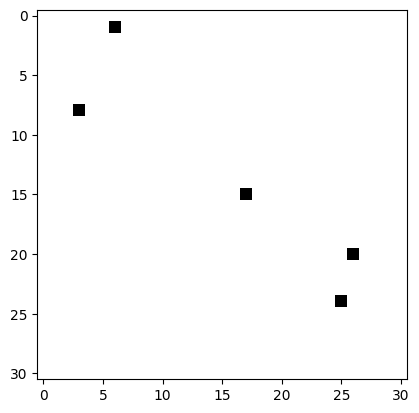

161it [03:10,  1.06it/s]

91.0477691590786 0.5690485572442412


171it [03:18,  1.31it/s]

96.36264145374298 0.5668390673749587


181it [03:26,  1.33it/s]

101.73723447322845 0.5652068581846025


191it [03:33,  1.29it/s]

107.39389488101006 0.5652310256895267


200it [03:40,  1.33it/s]

113.24931451678276 0.5662465725839138
113.24931451678276 0.5662465725839138


100%|██████████| 31/31 [00:22<00:00,  1.35it/s]


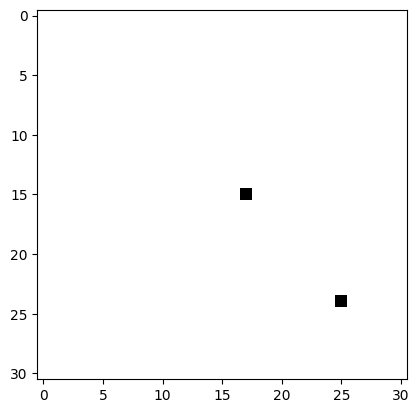

211it [04:11,  1.05it/s]

118.61433285474777 0.5648301564511798


221it [04:19,  1.33it/s]

124.29886394739151 0.5649948361245068


231it [04:27,  1.14it/s]

130.02718284726143 0.5653355775967889


241it [04:35,  1.32it/s]

135.97220155596733 0.5665508398165305


250it [04:41,  1.30it/s]

141.39892369508743 0.5655956947803498
141.39892369508743 0.5655956947803498


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


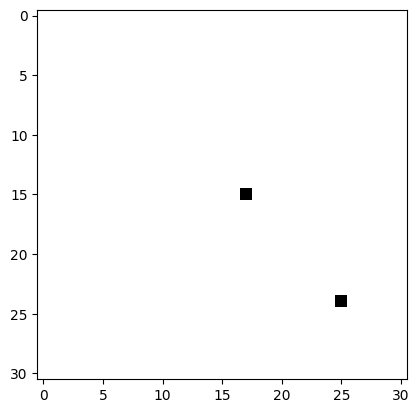

261it [05:13,  1.03it/s]

146.77823039889336 0.5645316553803591


271it [05:20,  1.28it/s]

152.23438891768456 0.5638310700654984


281it [05:28,  1.34it/s]

157.99996200203896 0.5642855785787105


291it [05:35,  1.34it/s]

163.15543606877327 0.5626049519612871


300it [05:42,  1.32it/s]

169.14811530709267 0.5638270510236422
169.14811530709267 0.5638270510236422


100%|██████████| 31/31 [00:22<00:00,  1.38it/s]


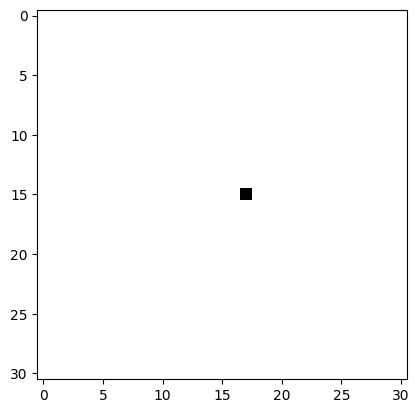

311it [06:13,  1.04it/s]

174.67723786830902 0.563474960865513


321it [06:21,  1.34it/s]

180.29687690734863 0.5634277403354645


331it [06:28,  1.34it/s]

185.95516070723534 0.5635004869916223


341it [06:36,  1.32it/s]

191.65200978517532 0.5636823817211039


350it [06:42,  1.28it/s]

197.03455936908722 0.5629558839116777
197.03455936908722 0.5629558839116777


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


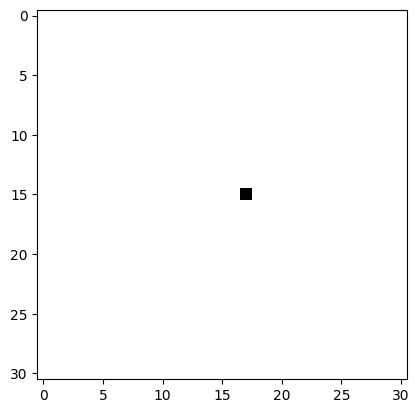

361it [07:14,  1.06it/s]

202.76677230000496 0.5632410341666805


371it [07:21,  1.32it/s]

208.34521216154099 0.5630951680041648


381it [07:29,  1.31it/s]

213.93437480926514 0.5629851968664872


384it [07:31,  1.18s/it]
11it [00:08,  1.31it/s]22:33<52:38, 451.24s/it]  

5.743653863668442 0.5743653863668442


21it [00:16,  1.34it/s]

11.064442843198776 0.5532221421599388


31it [00:23,  1.32it/s]

16.36584746837616 0.545528248945872


41it [00:31,  1.29it/s]

21.657789707183838 0.541444742679596


50it [00:38,  1.33it/s]

27.203421980142593 0.5440684396028519
27.203421980142593 0.5440684396028519


100%|██████████| 31/31 [00:22<00:00,  1.36it/s]


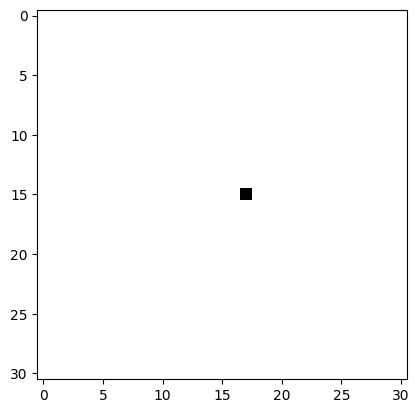

61it [01:09,  1.07it/s]

32.81790378689766 0.546965063114961


71it [01:16,  1.33it/s]

38.78208085894585 0.5540297265563693


81it [01:24,  1.33it/s]

44.794330418109894 0.5599291302263737


84it [01:26,  1.04s/it]
 30%|███       | 3/10 [24:00<56:00, 480.07s/it]


KeyboardInterrupt: 

In [43]:
## Define gradient clipping value
from tqdm import tqdm

previous_loss = 1e9
cur_loss = 1e9
steps_without_improv = 0
model.train()
# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0.0

    for idx, (batch_tiles, batch_labels, _) in tqdm(enumerate(dataloader), position=0, leave=True):
        # Move the data to GPU
        batch_labels = batch_labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
        outputs = outputs.to(device)
        batch_tiles = batch_tiles.to(device)
        outputs = model(outputs)
        # Calculate loss
        loss = criterion(outputs, batch_labels)
        # Scale the loss, compute gradients
        loss.backward()
        optimizer.step()

        # Track running loss for the epoch
        running_loss += loss.item()
        if idx% 10 == 0 and idx > 0:
             print(running_loss, running_loss/idx)
        if idx % 50 == 0 and idx != 0:
            print(running_loss, running_loss/idx)
            if running_loss/idx < 0.05:
                print(f"Final loss {running_loss/len(dataloader)}")
                break
            with torch.no_grad():
                ans = []
                for batch_tiles, batch_labels, corners in tqdm(valid_dataloader, position=0, leave=True):
                    batch_labels = batch_labels.float().to(device)
                
                
                    outputs = calc_fractal_features(batch_tiles, z_step=z_step, scales=scales)
                    outputs = outputs.to(device)
                    batch_tiles = batch_tiles.to(device)
                    outputs = model(outputs)
                    predictions = torch.sigmoid(outputs)
                    ans.extend(predictions.squeeze(1).cpu().detach().numpy() >= 0.5)
                    # print(len(ans))
                plt.imshow(np.array(ans).reshape(31, 31), cmap = "gray")
                plt.show()
                    

    # Scheduler step
    scheduler.step()

    cur_loss = running_loss/len(dataloader)
    if cur_loss < previous_loss:
        steps_without_improv = 0
        previous_loss = cur_loss
    else:
        steps_without_improv += 1


    if running_loss/len(dataloader) < 0.05 or steps_without_improv >= 2:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")
